In [1]:
import pandas as pd
import numpy as np
import glob
import re
import xml.etree.ElementTree as et
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import itertools
from sklearn.manifold import TSNE
import umap
import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data
import os
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance

class ALS_RNAseq:
    def __init__(self, data_path="./Data", annotation_file="GSE124439_family.xml"):
        self.data_path = data_path
        self.annotation_file = annotation_file
        self.__data_matrix = None
        self.__annotations = None

    def load_rna_counts(self):
        pdList = []
        for fname in glob.glob(self.data_path + "/*.txt"):
            df = pd.read_table(fname)
            sample_name = re.search("GSM\d+", fname).group()
            df.rename(index=df["gene/TE"], inplace=True)
            df.drop(columns=df.columns[0], axis=1, inplace=True)
            df.rename(columns={df.columns[0]: sample_name}, inplace=True)
            pdList.append(df)
        df = pd.concat(pdList, axis=1).transpose()
        # test if the data is loaded correctly
        
        test1 = df.loc['GSM3533230', 'A1BG'] == 42
        test2 = df.loc['GSM3533233', 'A2M'] == 2131
        test3 = df.loc['GSM3533394', 'AACS'] == 1273
        
        if test1 and test2 and test3:
            print("Data loaded correctly")
        else :
            print("Data not loaded correctly")
            
        df = df.loc[~(df == 0).all(axis=1)]

        threshold = len(df) * 0.01

        non_zero_counts = (df > 0).sum()

        filtered_columns = non_zero_counts[non_zero_counts >= threshold].index

        df = df[filtered_columns]
        
        self.__data_matrix = df

    def load_annotations(self):
        data_annotation = pd.DataFrame(columns=['Sample_id', 'Cns_subregion', 'Tissue_Type', 'Subject_Id', 'sample_group'])
        xtree = et.parse(f'{self.data_path}/{self.annotation_file}')
        xroot = xtree.getroot()
        sample_id = cns_subregion = tissue_type = subject_id = sample_group = None
        for sample in xroot.iter("{http://www.ncbi.nlm.nih.gov/geo/info/MINiML}Sample"):
            sample_id = sample.attrib['iid']
            tissue_type = None
            cns_subregion = None
            subject_id = None
            als_status = 0  # Default to 0, indicating no ALS
            for characteristic in sample.iter("{http://www.ncbi.nlm.nih.gov/geo/info/MINiML}Characteristics"):
                tag = characteristic.attrib['tag']
                text = characteristic.text.strip()
                if tag == "tissue type":
                    tissue_type = text
                elif tag == "cns subregion":
                    cns_subregion = text
                elif tag == "subject id":
                    subject_id = text
                elif tag == "sample group":
                        sample_group = text
                temp_df = pd.DataFrame({
                    'Sample_id': [sample_id],
                    'Cns_subregion': [cns_subregion],
                    'Tissue_Type': [tissue_type],
                    'Subject_Id': [subject_id],
                    'sample_group': [sample_group] 
                })
            data_annotation = pd.concat([data_annotation, temp_df], ignore_index=True)
        self.__annotations = data_annotation


    def get_data_matrix(self):
        return self.__data_matrix

    def get_annotations(self):
        return self.__annotations

    def standardize_data(self):
        scaler = StandardScaler()
        self.__data_matrix = pd.DataFrame(scaler.fit_transform(self.__data_matrix.values), 
                                          index=self.__data_matrix.index, 
                                          columns=self.__data_matrix.columns)

    def perform_pca(self, variance_threshold=0.95):
        pca_full = PCA()
        scaler = StandardScaler()
        df = pd.DataFrame(scaler.fit_transform(self.__data_matrix.values), 
                                          index=self.__data_matrix.index, 
                                          columns=self.__data_matrix.columns)
        principal_components_full = pca_full.fit_transform(df)
        explained_variance_ratio_full = pca_full.explained_variance_ratio_

        # Step 2: Calculate cumulative explained variance to determine the number of components
        cumulative_variance = explained_variance_ratio_full.cumsum()
        n_components = (cumulative_variance < variance_threshold).sum() + 1

        # Optional Step 3: Refit PCA with the determined number of components
        pca = PCA(n_components=n_components)
        principal_components = pca.fit_transform(self.__data_matrix.values)
        explained_variance_ratio = pca.explained_variance_ratio_

        return principal_components, explained_variance_ratio, n_components

   

    def plot_pca(self, pca_results, variance_ratio, n_components):
        # Generate PCA DataFrame
        pca_df = pd.DataFrame(data=pca_results, columns=[f'PC{i+1}' for i in range(n_components)], index=self.__data_matrix.index)
        merged_df = pca_df.join(self.__annotations.set_index('Sample_id')['sample_group'])
        
        # Define colors for each sample_group
        color_map = {
            'Non-Neurological Control': 'yellow',
            "ALS Spectrum MND": 'red',
            'Others': 'blue'  # Assuming 'Others' is the default
        }
        
        # Plot 5 combination of principal components
        pairs = list(itertools.combinations(range(n_components), 2))
        for (i, j) in pairs:
            pc1, pc2 = f'PC{i+1}', f'PC{j+1}'
            plt.figure(figsize=(10, 7))
            colors = [color_map.get(group, 'blue') for group in merged_df['sample_group']]
            
            plt.scatter(merged_df[pc1], merged_df[pc2], color=colors)
            
            # Custom legend
            legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                            for label, color in color_map.items()]
            plt.legend(handles=legend_elements, title="Sample Group")
            
            plt.xlabel(pc1)
            plt.ylabel(pc2)
            plt.title(f'PCA of ALS RNA-seq Data - {pc1} vs. {pc2}')
            plt.show()


    def __str__(self):
        return f"ALS RNAseq Dataset with {self.__data_matrix.shape[0]} samples and {self.__data_matrix.shape[1]} genes."
    
    def calculate_row_statistics(self):
        """Calculate the mean, median, and standard deviation for each row."""
        stats = self.__data_matrix.agg(['mean', 'median', 'std'], axis=1)
        return stats
    def calculate_column_statistics(self):
        """Calculate the mean, median, and standard deviation for each column."""
        stats = self.__data_matrix.agg(['mean', 'median', 'std'], axis=0)
        return stats
    
    def plot_piechart(self):
        # this function plots a pie chart of the als and Cns subregion in one piechat
        # of the patients
        # get the data
        data = self.__annotations
        # get the count of the Cns subregion
        cns_subregion_count = data['Cns_subregion'].value_counts()
        # get the count of the ALS status
        als_count = data['sample_group'].value_counts()
        # plot the pie chart
        fig, ax = plt.subplots(1, 2, figsize=(15, 7))
        ax[0].pie(cns_subregion_count, labels=cns_subregion_count.index, autopct='%1.1f%%', startangle=90)
        ax[0].set_title('Cns Subregion')
        ax[1].pie(als_count, labels=als_count.index, autopct='%1.1f%%', startangle=90)
        ax[1].set_title('ALS Status')
        plt.show()
    # Now the same thing with a bar chart
    def plot_barchart(self):
        # this function plots a bar chart of the als and Cns subregion in one bar chart
        # of the patients
        # get the data
        data = self.__annotations
        # get the count of the Cns subregion
        cns_subregion_count = data['Cns_subregion'].value_counts()
        # get the count of the ALS status
        als_count = data['sample_group'].value_counts()
        # plot the bar chart
        fig, ax = plt.subplots(1, 2, figsize=(15, 7))
        cns_subregion_count.plot(kind='bar', ax=ax[0])
        ax[0].set_title('Cns Subregion')
        als_count.plot(kind='bar', ax=ax[1])
        ax[1].set_title('ALS Status')
        plt.show()

        
    def calculate_sample_statistics(self):
        # Calculer la moyenne, la médiane et l'écart type pour chaque échantillon
        sample_stats = self.__data_matrix.agg(['mean', 'median', 'std'], axis=1) 
        # Ajouter les annotations pour chaque échantillon
        sample_stats = sample_stats.join(self.__annotations.set_index('Sample_id'))
        return sample_stats

    
    def plot_histograms(self):
        # Histogramme des moyennes
        plt.figure(figsize=(10, 6))
        sns.histplot(self.__data_matrix.mean(axis=1))
        plt.title('Distribution des moyennes de l\'expression génique')
        plt.xlabel('Moyenne de l\'expression génique')
        plt.ylabel('Nombre d\'échantillons')
        plt.show()

        # Histogramme des médianes
        plt.figure(figsize=(10, 6))
        sns.histplot(self.__data_matrix.median(axis=1))
        plt.title('Distribution des médianes de l\'expression génique')
        plt.xlabel('Médiane de l\'expression génique')
        plt.ylabel('Nombre d\'échantillons')
        plt.show()

        # Histogramme des écart-types
        plt.figure(figsize=(10, 6))
        sns.histplot(self.__data_matrix.std(axis=1))
        plt.title('Distribution des écart-types de l\'expression génique')
        plt.xlabel('Écart-type de l\'expression génique')
        plt.ylabel('Nombre d\'échantillons')
        plt.show()
        
    def summary_tables(self):
        # Tableau récapitulatif des statistiques descriptives pour chaque échantillon
        sample_stats = self.calculate_sample_statistics()
        print("Summary Statistics for Each Sample:")
        print(sample_stats)

        # Tableau récapitulatif du nombre d'échantillons par groupe de maladies
        disease_group_counts = self.__annotations['sample_group'].value_counts().reset_index()
        disease_group_counts.columns = ['Disease Group', 'Sample Count']
        print("\nNumber of Samples per Disease Group:")
        print(disease_group_counts)

        # Tableau récapitulatif du nombre d'échantillons par source
        source_counts = self.__annotations['Tissue_Type'].value_counts().reset_index()
        source_counts.columns = ['Sample Source', 'Sample Count']
        print("\nNumber of Samples per Source:")
        print(source_counts)

        # Tableau récapitulatif du nombre d'échantillons par individu
        sample_counts_per_individual = self.__annotations['Subject_Id'].value_counts().reset_index()
        sample_counts_per_individual.columns = ['Subject Id', 'Sample Count']
        print("\nSample Count per Individual:")
        print(sample_counts_per_individual)
        
    def calculate_gene_statistics(self):
        # Filter the annotations to find Sample IDs of healthy individuals
        healthy_sample_ids = self.__annotations[self.__annotations['sample_group'] == "Non-Neurological Control"]['Sample_id']

        # Filter the data matrix to include only columns corresponding to healthy individuals
        valid_ids = self.__data_matrix.index.intersection(healthy_sample_ids)

        # Filter the data matrix to include only rows with valid_ids
        healthy_data_matrix = self.__data_matrix.loc[valid_ids]

        # Calculate mean, median, and standard deviation for each gene (row)
        gene_statistics1 = healthy_data_matrix.agg(['mean', 'median', 'std']).transpose()

        # Rename the columns
        gene_statistics1.columns = ['mean_healthy', 'median_healthy', 'std_healthy']

        # Filter the annotations to find Sample IDs of ALS individuals
        als_sample_ids = self.__annotations[self.__annotations['sample_group'] == "ALS Spectrum MND"]['Sample_id']

        # Filter the data matrix to include only columns corresponding to ALS individuals
        valid_ids = self.__data_matrix.index.intersection(als_sample_ids)

        # Filter the data matrix to include only rows with valid_ids
        als_data_matrix = self.__data_matrix.loc[valid_ids]

        # Calculate mean, median, and standard deviation for each gene (row)
        gene_statistics2 = als_data_matrix.agg(['mean', 'median', 'std']).transpose()

        # Rename the columns
        gene_statistics2.columns = ['mean_als', 'median_als', 'std_als']

        # Merge the two dataframes
        gene_statistics = gene_statistics1.join(gene_statistics2)

        gene_statistics['difference_percentage'] = (abs(gene_statistics['mean_als'] - gene_statistics['mean_healthy'])/
                                gene_statistics[['mean_als', 'mean_healthy']].min(axis=1))

        # Order the DataFrame based on the 'difference_percentage' column
        gene_statistics = gene_statistics.sort_values(by='difference_percentage', ascending=False)



        return gene_statistics

    def plot_gene_expression_heatmap(self, top_n_genes=20):
        # Select top N genes based on highest standard deviation
        top_genes = self.__data_matrix.std(axis=1).nlargest(top_n_genes).index
        top_gene_data = self.__data_matrix.loc[top_genes]

        # Plot heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(top_gene_data, cmap='viridis', yticklabels=True)
        plt.title('Heatmap of Top Genes by Standard Deviation')
        plt.xlabel('Samples')
        plt.ylabel('Genes')
        plt.show()
    def data_overview(self):
        dataset_overview = {
            'Number of Samples': len(self.__data_matrix),
            'Number of Genes': len(self.__data_matrix.columns),
            'Number of Disease Groups': len(self.__annotations['sample_group'].unique()),
            'Variety of Sample Sources': self.__annotations['Tissue_Type'].unique().tolist(),
            'Count of Samples per Individual': self.__annotations['Subject_Id'].value_counts().to_dict()
        }
        print("\nDataset Overview:")
        for key, value in dataset_overview.items():
            print(f"{key} : {value}")


    def perform_tsne(self, n_components=2, perplexity=30.0, random_state=42):
        tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
        tsne_results = tsne.fit_transform(self.__data_matrix.values)
        return tsne_results

    def perform_umap(self, n_components=2, n_neighbors=15, random_state=42):
        reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, random_state=random_state)
        umap_results = reducer.fit_transform(self.__data_matrix.values)
        return umap_results

    def plot_dimension_reduction(self, dr_results, method_name='Method', n_components=2):
        dr_df = pd.DataFrame(data=dr_results, columns=[f'{method_name} {i+1}' for i in range(n_components)], index=self.__data_matrix.index)
        merged_df = dr_df.join(self.__annotations.set_index('Sample_id')['sample_group'])

        # Define colors
        color_map = {
            'Non-Neurological Control': 'yellow',
            "ALS Spectrum MND": 'red',
            'Other Neurological Disorders': 'blue'
        }

        # Plot
        fig, ax = plt.subplots(figsize=(10, 7))
        for group, color in color_map.items():
            ix = merged_df['sample_group'] == group
            ax.scatter(merged_df.loc[ix, f'{method_name} 1'], merged_df.loc[ix, f'{method_name} 2'], c=color, label=group, s=50)
        ax.legend()
        plt.xlabel(f'{method_name} 1')
        plt.ylabel(f'{method_name} 2')
        plt.title(f'{method_name} Visualization of ALS RNA-seq Data')
        plt.show()


    def perform_differential_expression_analysis(self):
        counts_df = self.__data_matrix
        metadata = self.__annotations[['Sample_id', 'sample_group']].set_index('Sample_id')
        
        # Ensuring no NaN entries in the design factor
        metadata = metadata.dropna(subset=['sample_group'])
        counts_df = counts_df.loc[metadata.index]  # Sync samples
        
        # Initialize DefaultInference with desired number of CPUs
        inference = DefaultInference(n_cpus=4)
        
        # Initialize DeseqDataSet
        dds = DeseqDataSet(
            counts=counts_df,
            metadata=metadata,
            design_factors="sample_group",
            refit_cooks=True,
            inference=inference
        )
        
        # Perform analysis
        dds.deseq2()
        
        # Initialize DeseqStats for statistical analysis
        stat_res = DeseqStats(dds, inference=inference)
        stat_res.summary()
        results_df = stat_res.results_df
        
        
        # Optionally, save results if needed
        save = False
        if save:
            output_path = "./output_files/deseq_results"
            os.makedirs(output_path, exist_ok=True)
            results_df.to_csv(os.path.join(output_path, 'DEA_results.csv'))

        return results_df

    def plot_volcano(self):
    
        results_df = self.perform_differential_expression_analysis()
        # Create new columns in the DataFrame for plotting
        results_df['-log10(p-value)'] = -np.log10(results_df['pvalue'])        
        # Setup figure and axis
        plt.figure(figsize=(10, 8))
        plt.scatter(results_df['log2FoldChange'], results_df['-log10(p-value)'], color='gray', alpha=0.7)

        # Highlight significant genes with p-adjusted value < 0.05
        sig_genes = results_df[results_df['padj'] < 0.05]
        plt.scatter(sig_genes['log2FoldChange'], sig_genes['-log10(p-value)'],
                    color='red', alpha=0.7)

        # Adding labels and title
        plt.xlabel('Log2 Fold Change')
        plt.ylabel('-Log10 P-value')
        plt.title('Volcano plot of differential gene expression')

        # Add a line to indicate the significance threshold
        plt.axhline(y=-np.log10(0.05), color='blue', linestyle='--', label='p=0.05')
        plt.legend()

        plt.show()


    def perform_elastic_net(self):
        # Normalize data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.__data_matrix.values)
        y = self.__annotations['sample_group'].apply(lambda x: 1 if x == 'ALS Spectrum MND' else 0).values
        
        X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
       
        
        # Setup Elastic-Net with Cross-Validation
        elastic_net_cv = LogisticRegressionCV(
            penalty='elasticnet', 
            cv=3, 
            solver='saga', 
            l1_ratios=[0.25, 0.5, 0.75], 
            Cs=[0.1, 0.5, 1.0], 
            scoring='roc_auc', 
            max_iter=10000,
            random_state=42,
            n_jobs=-1
        )
        elastic_net_cv.fit(X_train, y_train)
        
        # Evaluate the model
        predictions = elastic_net_cv.predict(X_val)
        roc_auc = roc_auc_score(y_val, predictions)
        
        print(f'ROC AUC on training set: {roc_auc}')


        
        # Extract and rank genes based on their coefficients
        gene_importance = np.abs(elastic_net_cv.coef_[0])
        gene_names = self.__data_matrix.columns
        gene_ranking = sorted(zip(gene_names, gene_importance), key=lambda x: x[1], reverse=True)
        
        for gene, importance in gene_ranking[:10]:  # Print top 10 important genes
            print(f'Gene: {gene}, Importance: {importance}')
            
        
        return gene_ranking  # Return the full list if needed for further analysis
    

    def perform_xgboost_analysis(self):
        # Normalize data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.__data_matrix.values)
        y = self.__annotations['sample_group'].apply(lambda x: 1 if x == 'ALS Spectrum MND' else 0).values
        
        # Split the data into training and testing sets
        X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        
        # Train XGBoost Model
        model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        model.fit(X_train, y_train)
        
        # Get feature importances
        importances = model.feature_importances_
        gene_names = self.__data_matrix.columns
        
        # Create a DataFrame of features and their importance
        feature_importance_df = pd.DataFrame({'Gene': gene_names, 'Importance': importances})
        
        # Sort by importance
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        
        # Select the top 100 most important features
        top_features = feature_importance_df.head(100)
        
        # Plot feature importance for the top 100 features
        plt.figure(figsize=(10, 15))
        plt.barh(top_features['Gene'], top_features['Importance'])
        plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
        plt.xlabel('Feature Importance')
        plt.ylabel('Genes')
        plt.title('Top 100 Most Important Features')
        plt.show()
        
        # Evaluate the model on the test set
        accuracy = model.score(X_val, y_val)
        print(f'Accuracy on validation set: {accuracy}')
        y_pred = model.predict(X_val)
        balanced_acc = balanced_accuracy_score(y_val, y_pred)
        print(f'Balanced Accuracy on validation set: {balanced_acc}')


        return top_features # Return the top features for further analysis
    

    def aggregate_rankings(self):
        # Perform necessary analyses
        results_df = self.perform_differential_expression_analysis()
        results_df['DEA_Score'] = -np.log10(results_df['pvalue']) + abs(results_df['log2FoldChange'])
        results_df['DEA_Rank'] = results_df['DEA_Score'].rank(method='min', ascending=False)
        
        # Normalize DEA score to scale 0-1
        results_df['DEA_Score'] /= results_df['DEA_Score'].max()
        results_df['Gene'] = results_df.index

        elastic_net_ranking = self.perform_elastic_net()
        xgboost_ranking = self.perform_xgboost_analysis()

        # Convert rankings to DataFrames
        en_df = pd.DataFrame(elastic_net_ranking, columns=['Gene', 'EN_Importance'])
        en_df['EN_Rank'] = en_df['EN_Importance'].rank(method='min', ascending=False)
        en_df['EN_Importance'] /= en_df['EN_Importance'].max()

        xgb_df = xgboost_ranking
        xgb_df['XGB_Rank'] = xgb_df['Importance'].rank(method='min', ascending=False)
        xgb_df['Importance'] /= xgb_df['Importance'].max()
        #xgb_df.index.name = 'Gene'
        xgb_df.head()

        # Merge all data based on Gene
        combined_df = en_df.merge(xgb_df, on='Gene', how='outer').merge(results_df[['Gene', 'DEA_Score']], on='Gene', how='outer')
        combined_df.fillna(value={'EN_Importance': 0, 'Importance': 0, 'DEA_Score': 0}, inplace=True)  # Replace NaNs where genes do not appear in all analyses

        # Calculate combined score and final rank
        combined_df['Combined_Importance'] = combined_df['EN_Importance'] + combined_df['Importance'] + combined_df['DEA_Score']
        combined_df['Final_Rank'] = combined_df['Combined_Importance'].rank(method='min', ascending=False)

        # Get the top 100 genes
        top_100_genes = combined_df.sort_values(by='Final_Rank').head(100)
        
        print(top_100_genes)

        return top_100_genes
    


/home/karim/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-15 10:33:38.133597: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 10:33:38.133636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 10:33:38.134484: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-15 10:33:38.140101: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is o

# PART 1 : Preprocessing

In [2]:
# Instantiate the ALS_RNAseq class
als_data = ALS_RNAseq(data_path="./Data", annotation_file="GSE124439_family.xml")

# Load and preprocess RNA counts data
als_data.load_rna_counts()
print("RNA counts data loaded and preprocessed.")

# Load sample annotations
als_data.load_annotations()
print("Sample annotations loaded.")

Data loaded correctly
RNA counts data loaded and preprocessed.
Sample annotations loaded.


# PART 2 : Descriptive Analysis

## Sample Description:

Bar Charts for "Disease Groups" and Sample "Sources":


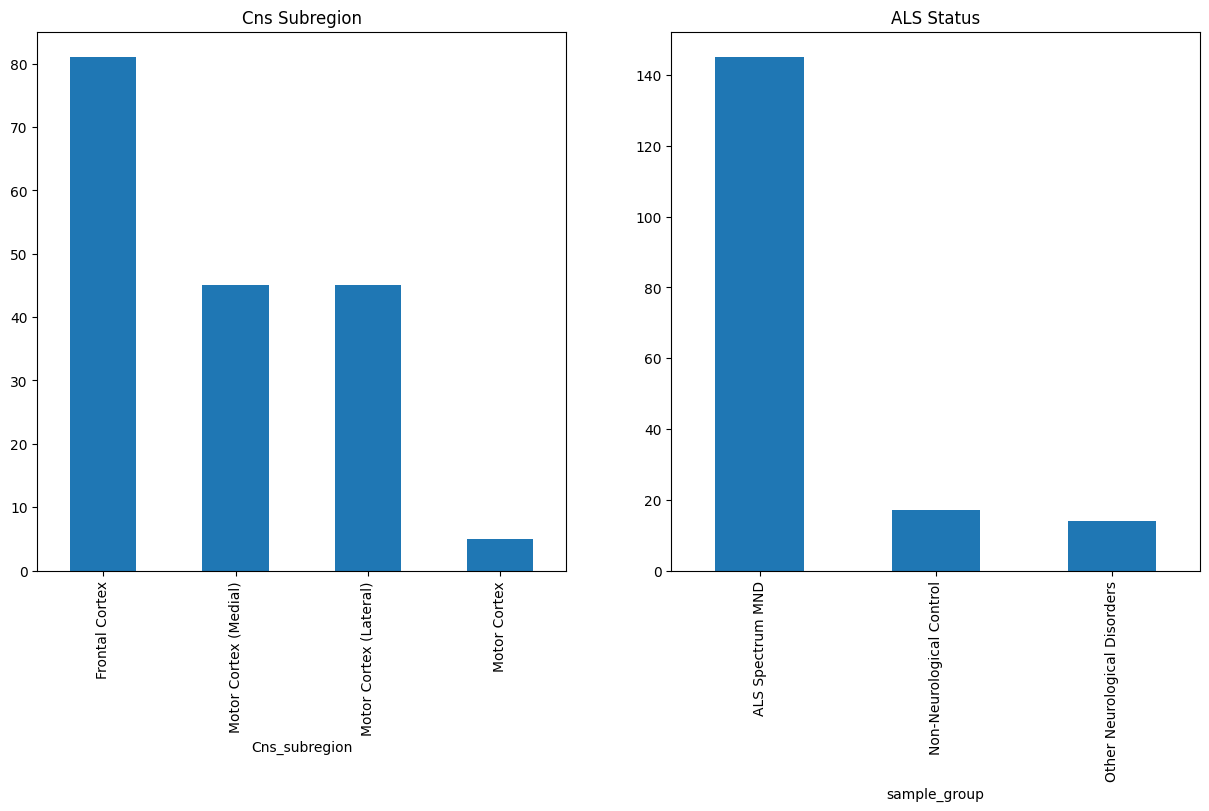

Histograms for Measures of Central Tendency and Dispersion:


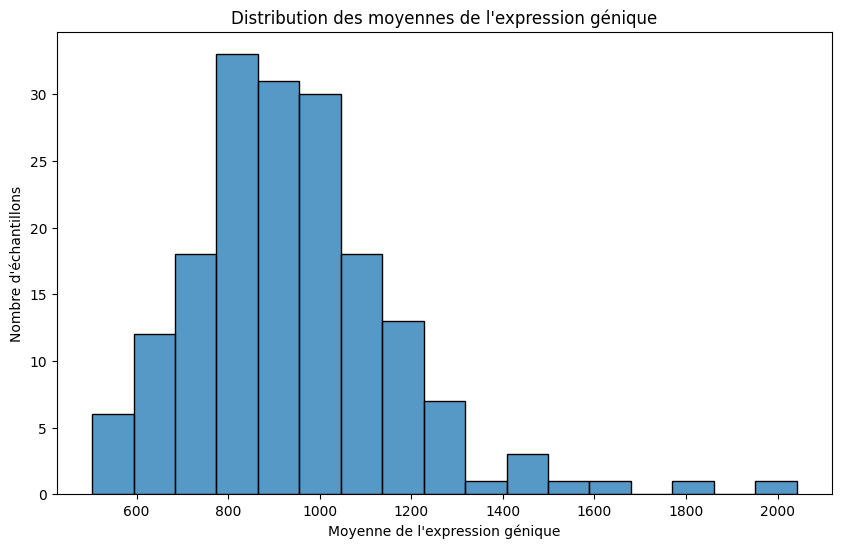

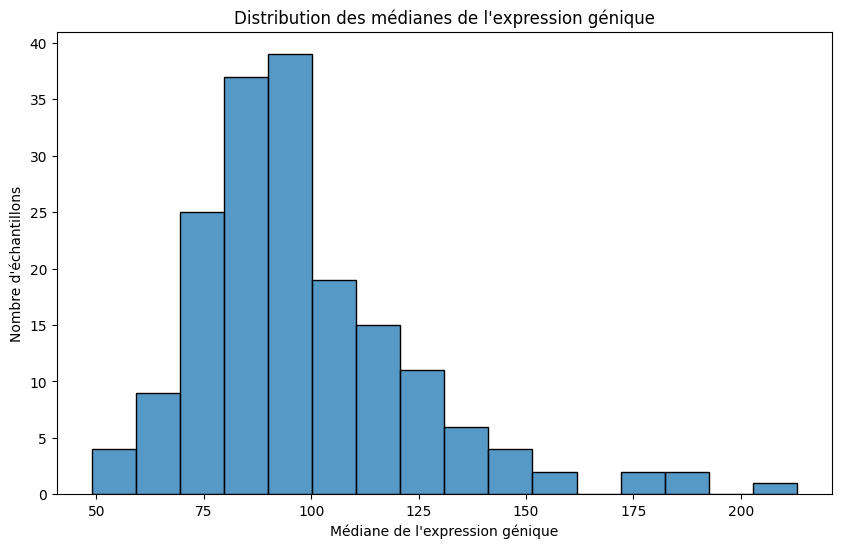

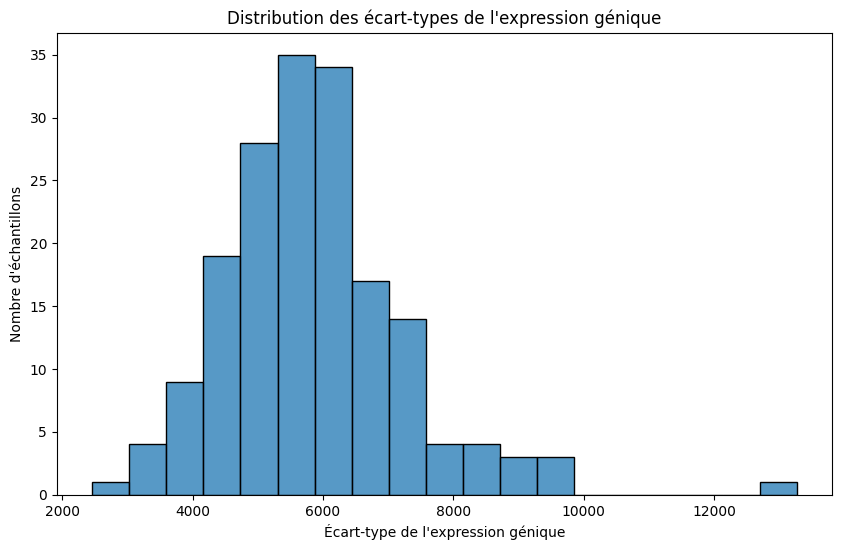

In [3]:
print('Bar Charts for "Disease Groups" and Sample "Sources":')
als_data.plot_barchart()

print('Histograms for Measures of Central Tendency and Dispersion:')
als_data.plot_histograms()

In [4]:
print('Summary Tables:')
als_data.summary_tables()

Summary Tables:
Summary Statistics for Each Sample:
                   mean  median          std           Cns_subregion  \
GSM3533328   719.903718    70.0  3199.747493  Motor Cortex (Lateral)   
GSM3533319   872.076032    91.0  4336.547628   Motor Cortex (Medial)   
GSM3533306   673.734218    62.0  3546.434658          Frontal Cortex   
GSM3533282   997.126476   110.0  6672.931771          Frontal Cortex   
GSM3533240  1149.395146   114.0  9349.332276          Frontal Cortex   
...                 ...     ...          ...                     ...   
GSM3533324   892.345433    92.0  4983.520842          Frontal Cortex   
GSM3533304  1035.047556   100.0  5608.282327   Motor Cortex (Medial)   
GSM3533291   984.403845   101.0  5060.405438   Motor Cortex (Medial)   
GSM3533339   747.761487    81.0  4497.434679  Motor Cortex (Lateral)   
GSM3533384   965.532039   102.0  6963.023927          Frontal Cortex   

                   Tissue_Type   Subject_Id              sample_group  
GSM3533328 

Heatmaps: 


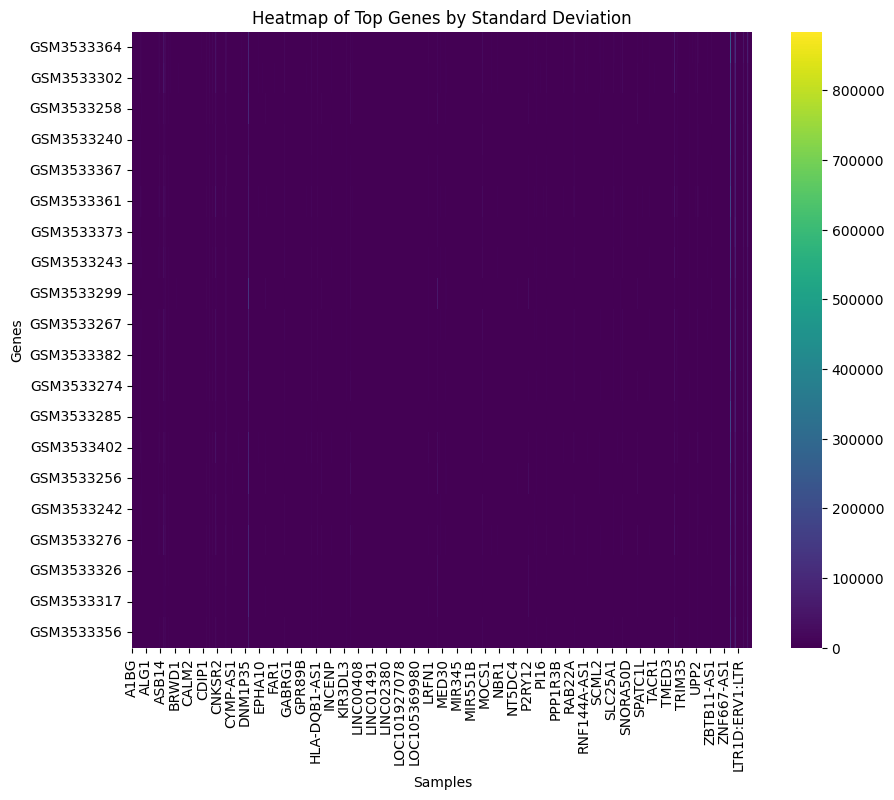

In [5]:
print('Heatmaps: ')
als_data.plot_gene_expression_heatmap()

## RNA Counts Description:

In [6]:
print('Gene Expression Overview:')
als_data.data_overview()

Gene Expression Overview:

Dataset Overview:
Number of Samples : 176
Number of Genes : 27357
Number of Disease Groups : 3
Variety of Sample Sources : ['post-mortem tissue']
Count of Samples per Individual : {'NEUEL133AK6': 3, 'NEUUE532LFF': 3, 'NEUEF397VVN': 3, 'NEUWZ373ZHA': 3, 'NEUAT369TG5': 3, 'NEUNW244GF0': 3, 'NEUTP019MY9': 3, 'NEUZX073BDK': 3, 'NEUKY135CV6': 3, 'NEUMT947ALA': 3, 'NEUEE593VY7': 3, 'NEUDT233ZZ1': 3, 'NEUYV496XLP': 3, 'NEUAP156PM4': 3, 'NEUEH612JPA': 3, 'NEURX991BWB': 3, 'JHU 73': 3, 'JHU 74': 3, 'JHU 83': 3, 'GWF14-01': 3, 'NEUDG727NTW': 3, 'NEUXT979EZV': 3, 'NEUWX086DGZ': 3, 'NEUHC282LVJ': 3, 'NEUFT454ZFP': 3, 'NEUDM397JGD': 3, 'NEUHD481VCL': 3, 'NEUDR086ZDQ': 3, 'NEUDG361GA9': 3, 'NEUKM699KKH': 3, 'NEUME287RK2': 3, 'NEUNW210GCW': 3, 'NEUNE940RZC': 2, 'NEURD711XCL': 2, 'NEUJZ255ZC5': 2, 'JHU 82': 2, 'JHU 80': 2, 'NEUZU200WEQ': 2, 'NEUTZ062XC5': 2, 'NEUMV641VYK': 2, 'NEUEC006FND': 2, 'NEULH901PYF': 2, 'NEUCW292DYJ': 2, 'NEUCV649UJK': 2, 'NEUGV399KJW': 2, 'NEUNL548Z

# Step 3 - PCA

PCA analysis completed with 8components


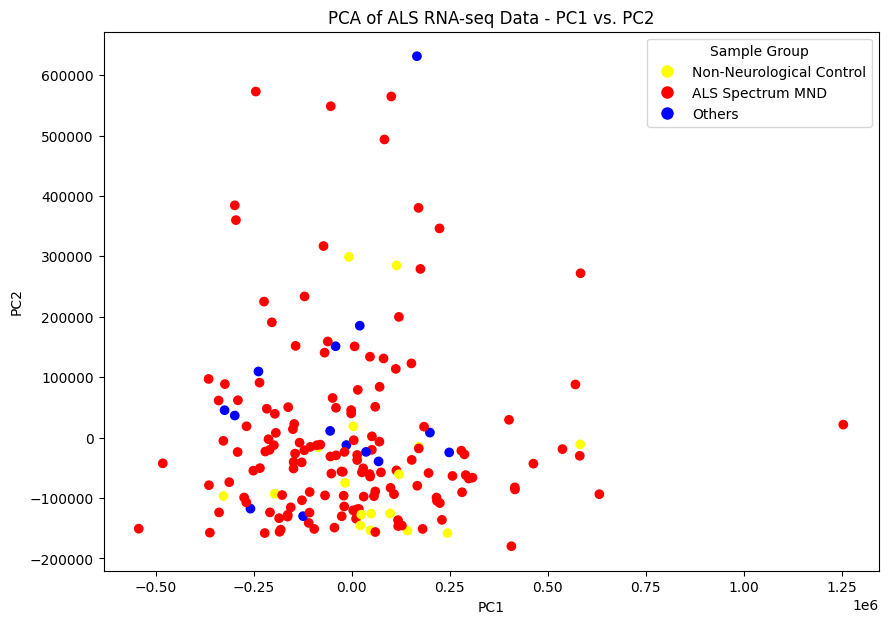

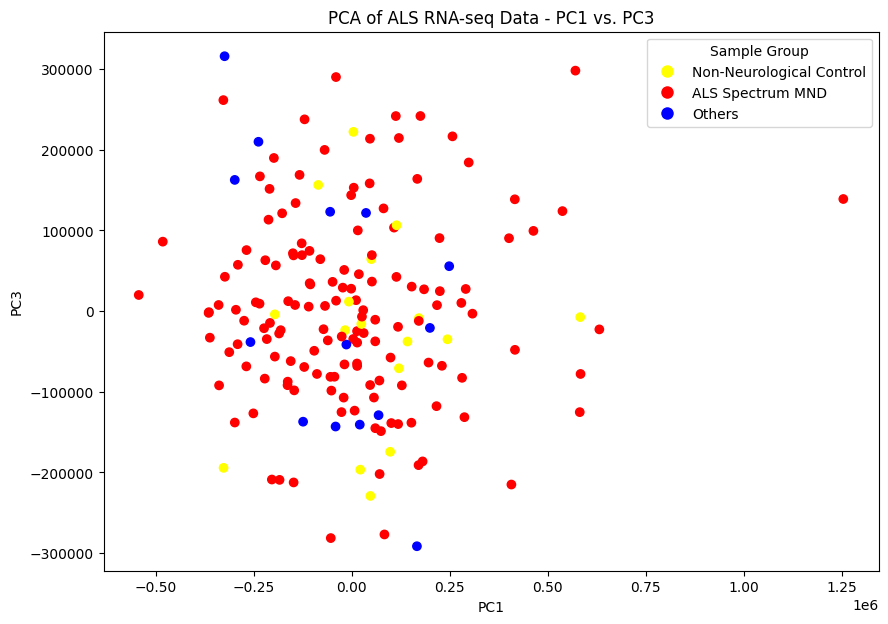

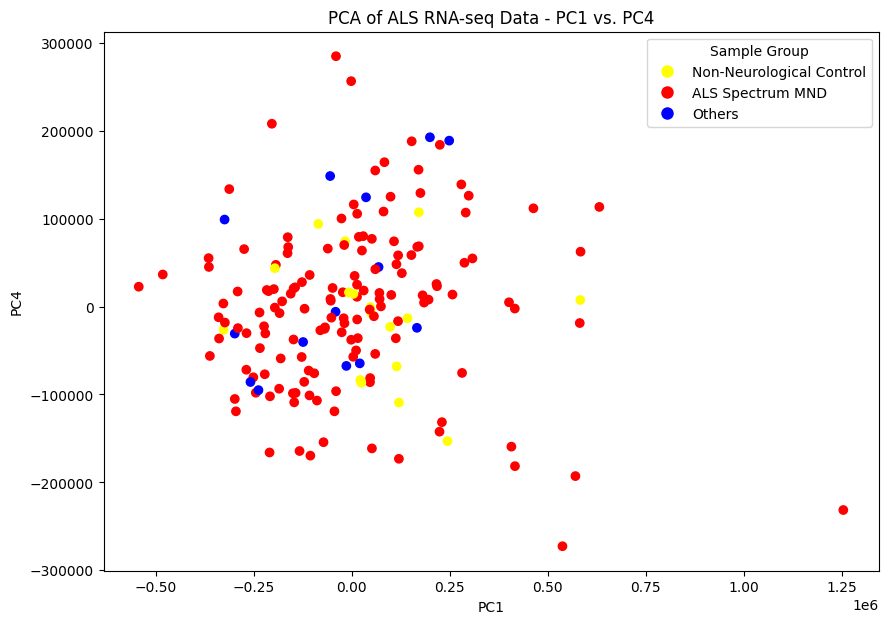

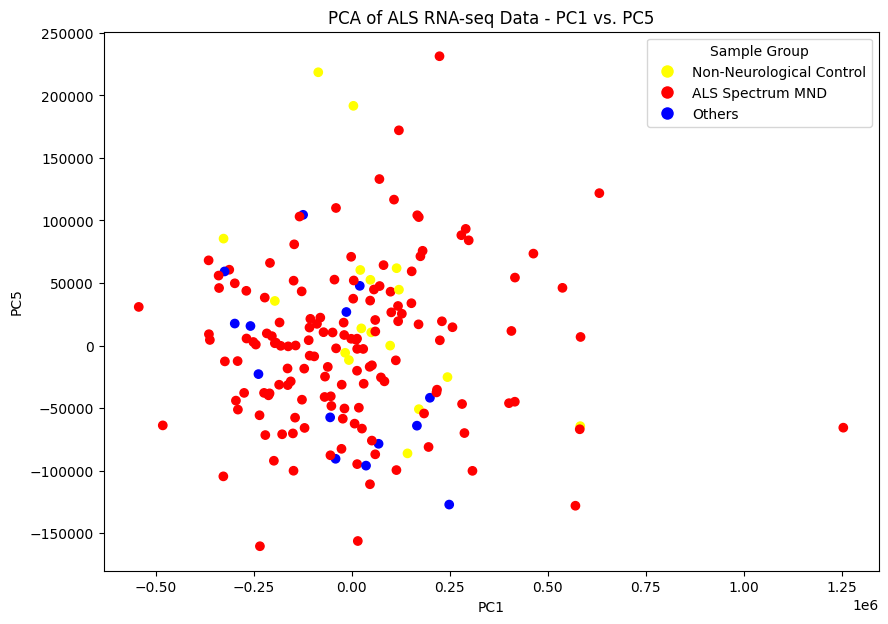

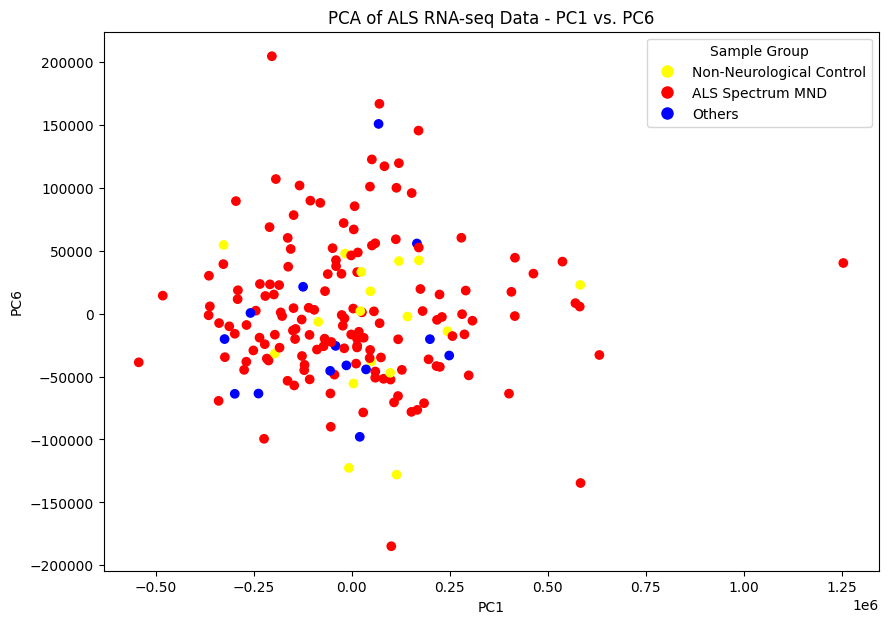

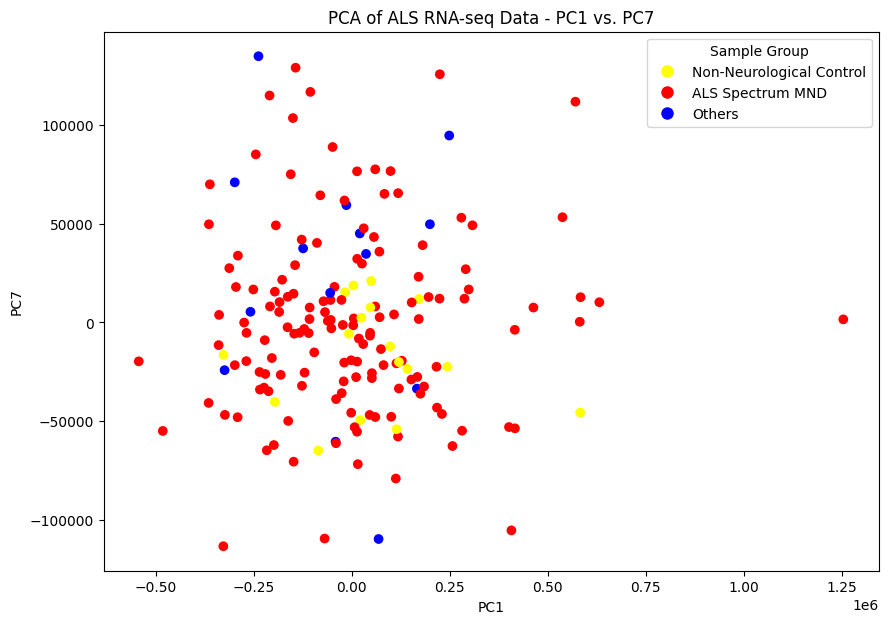

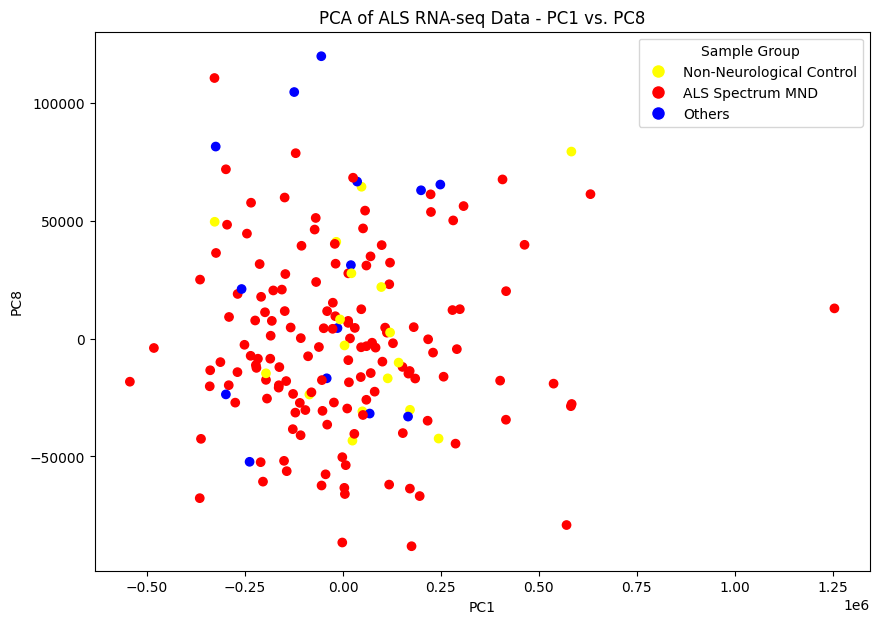

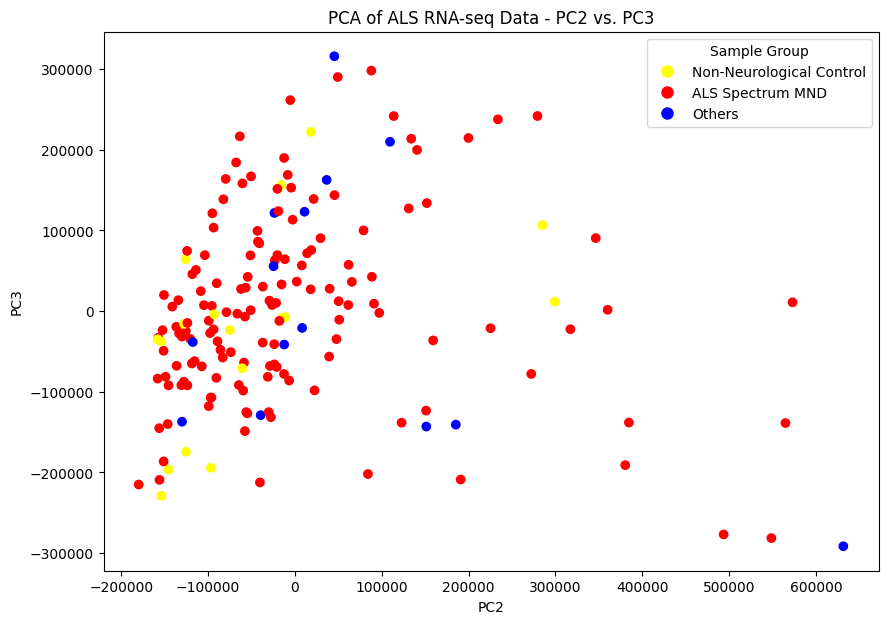

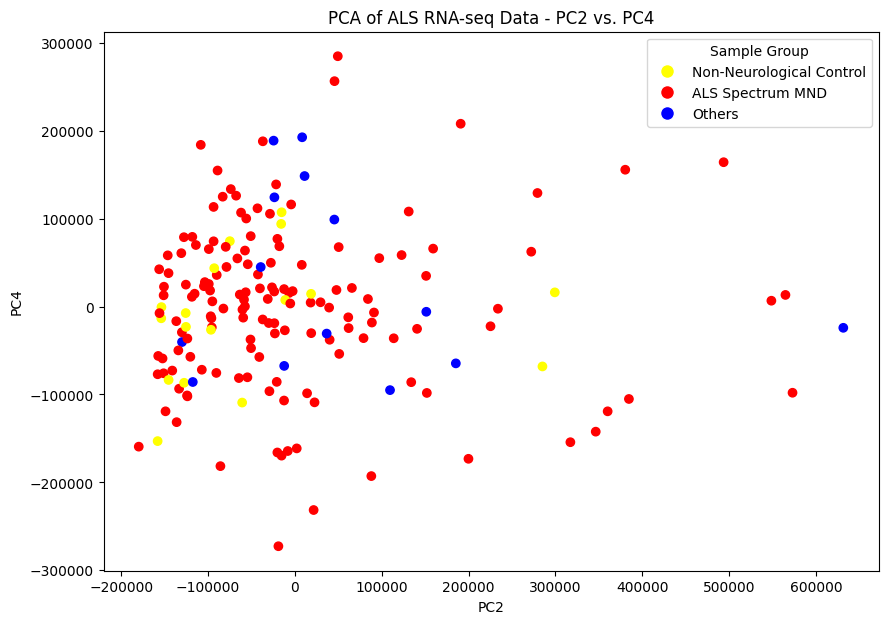

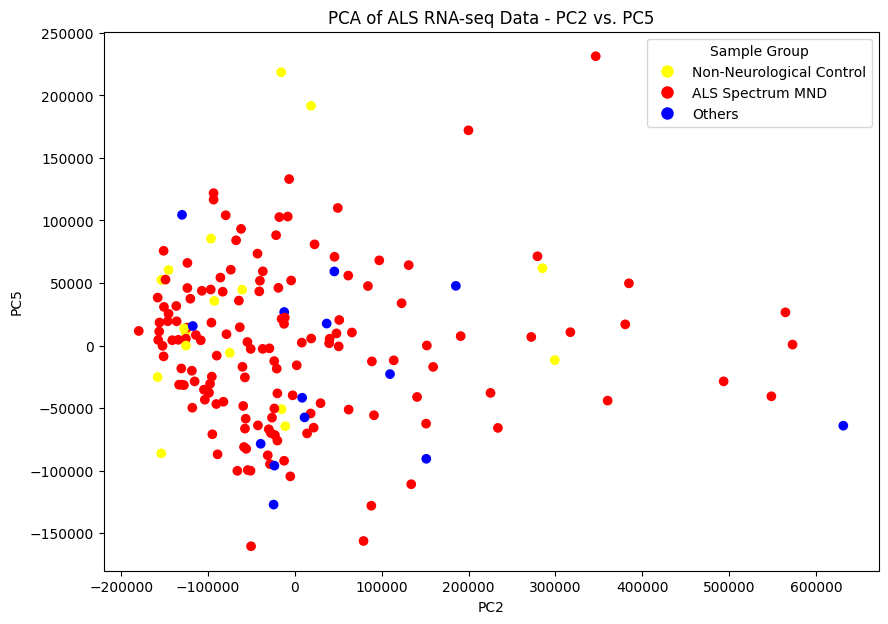

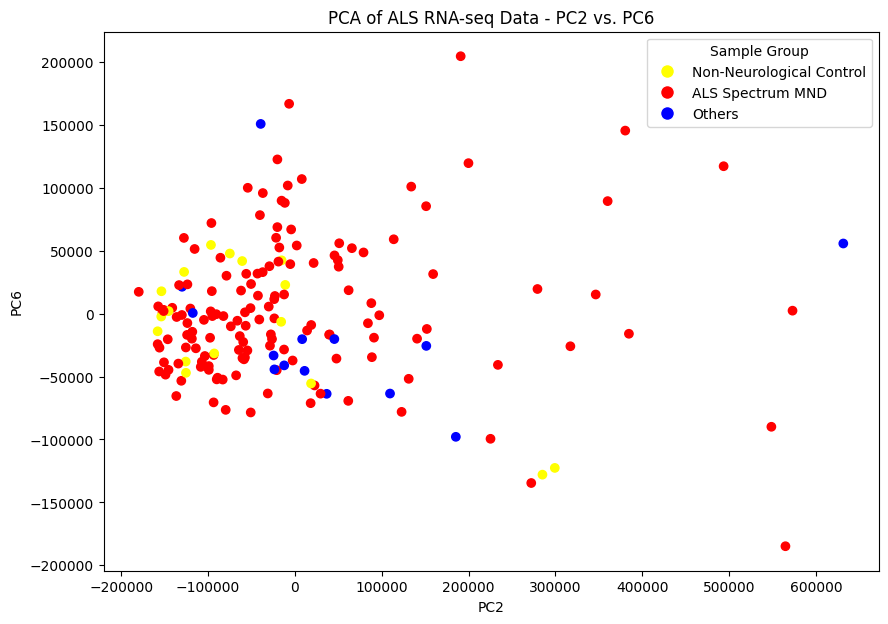

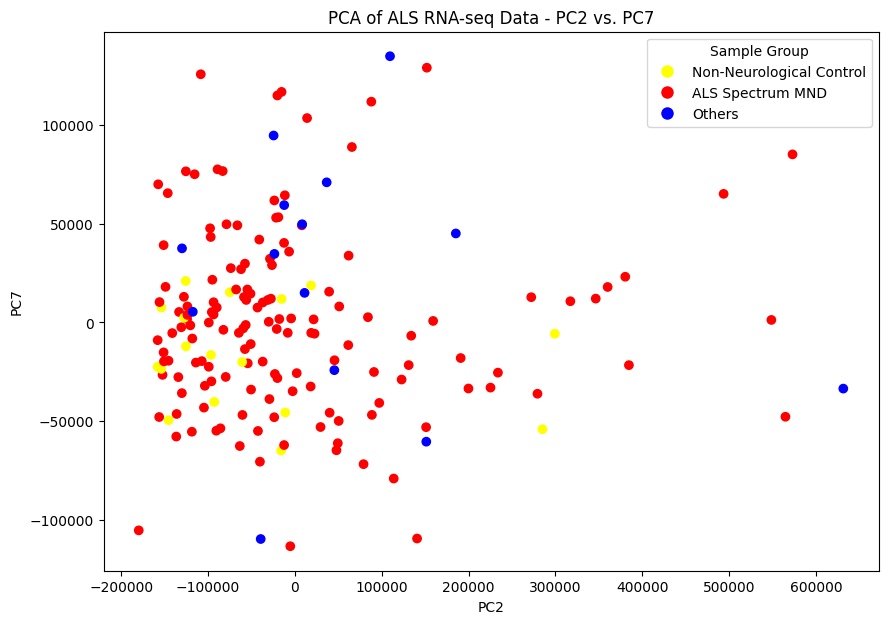

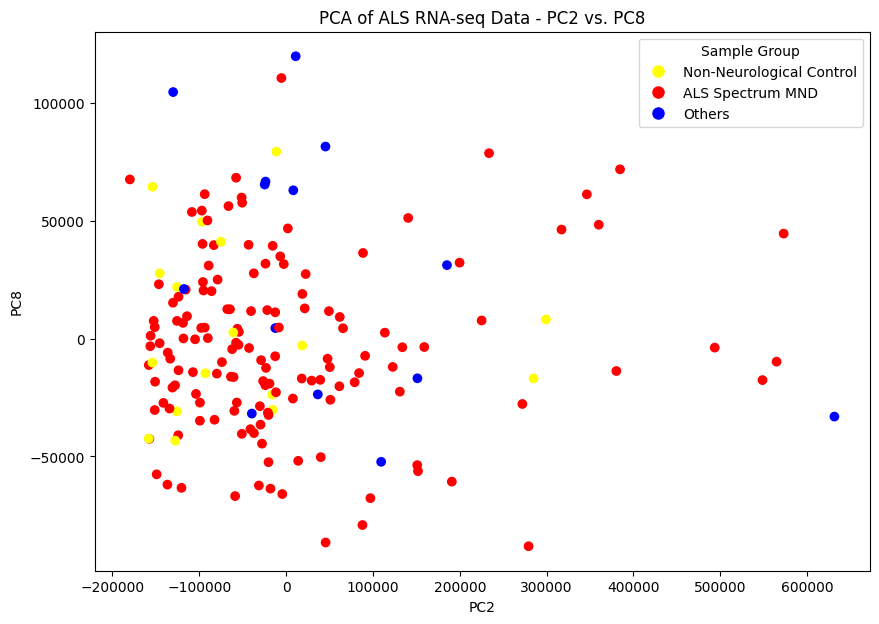

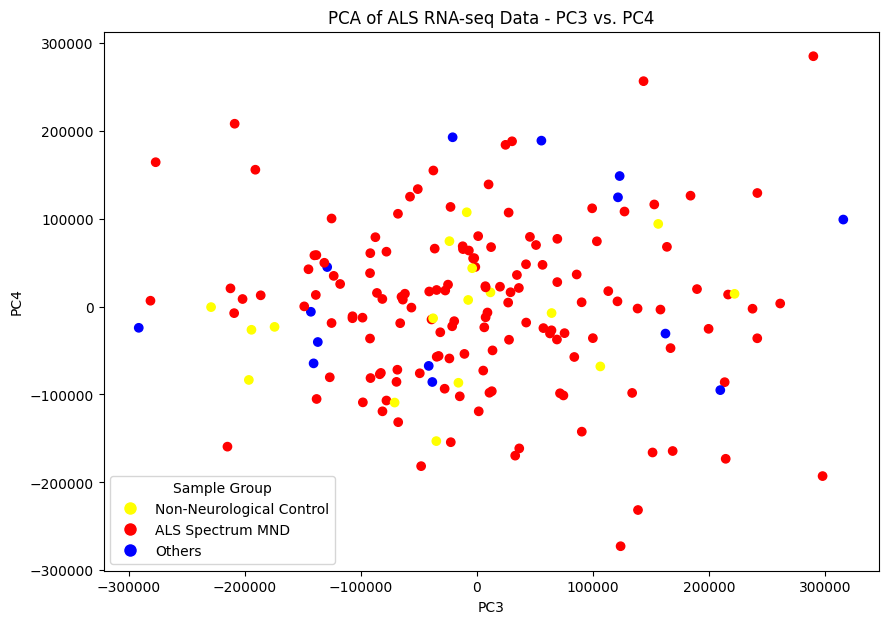

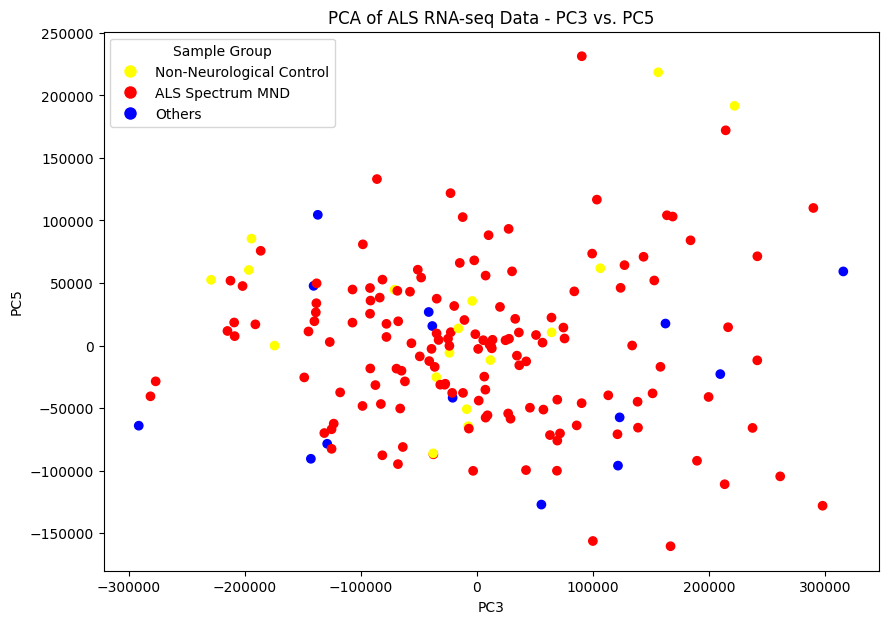

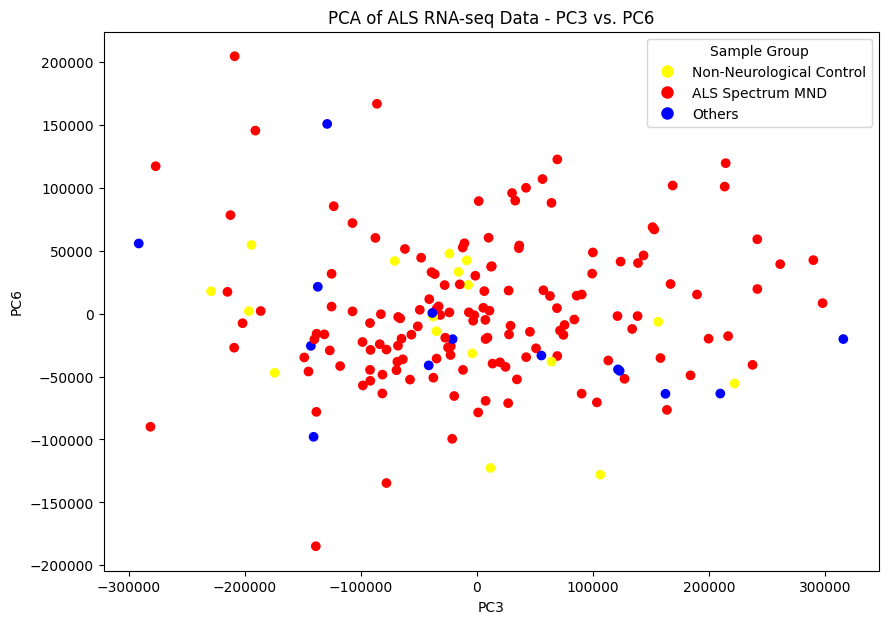

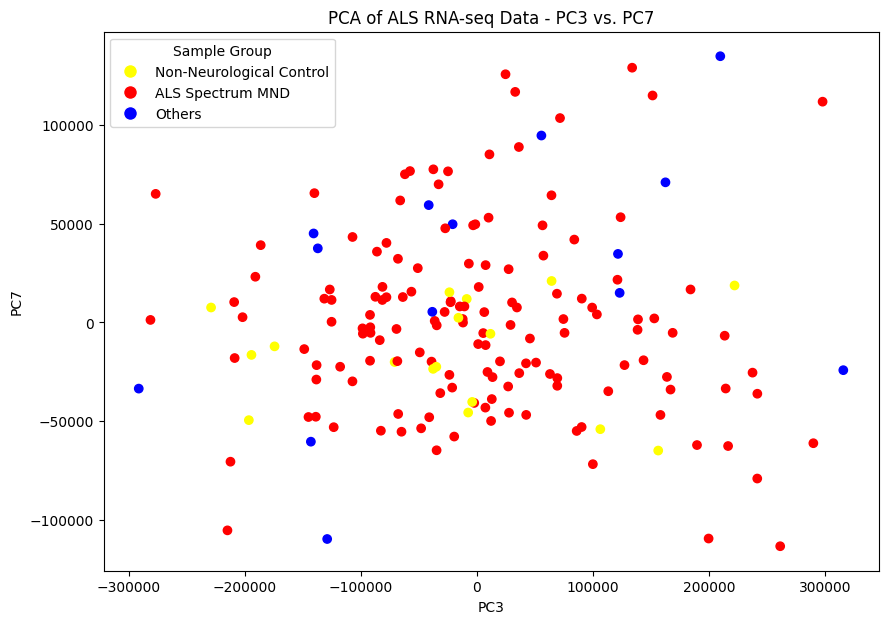

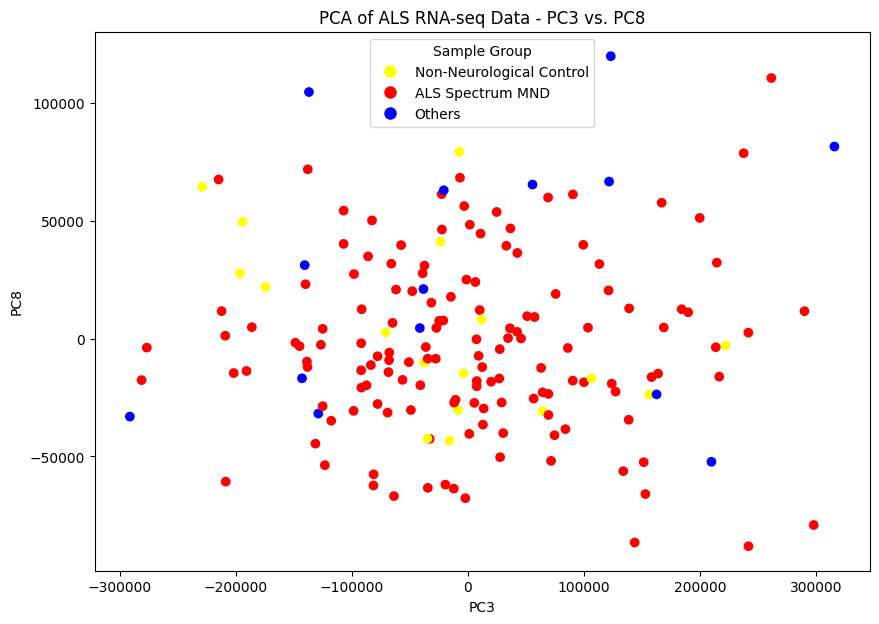

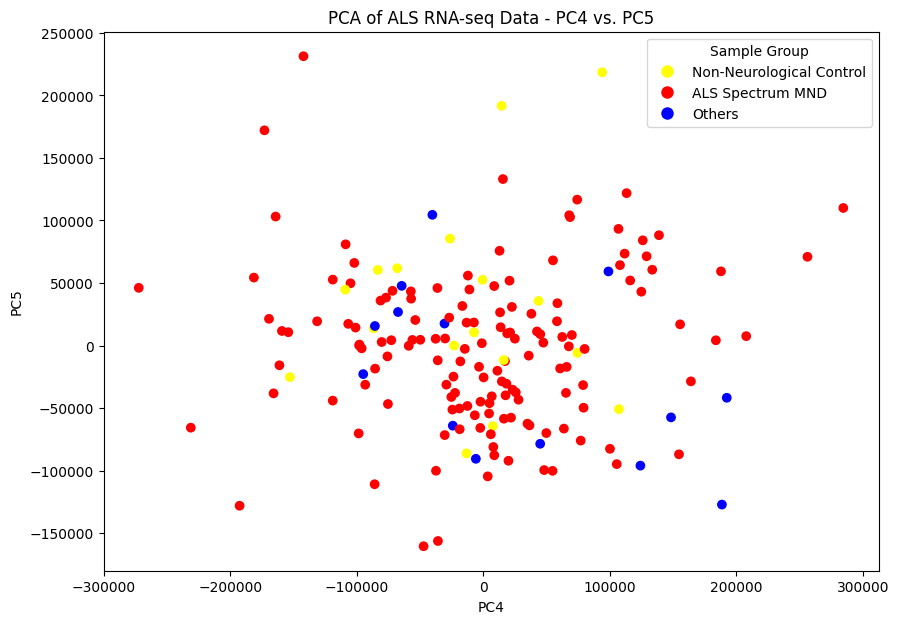

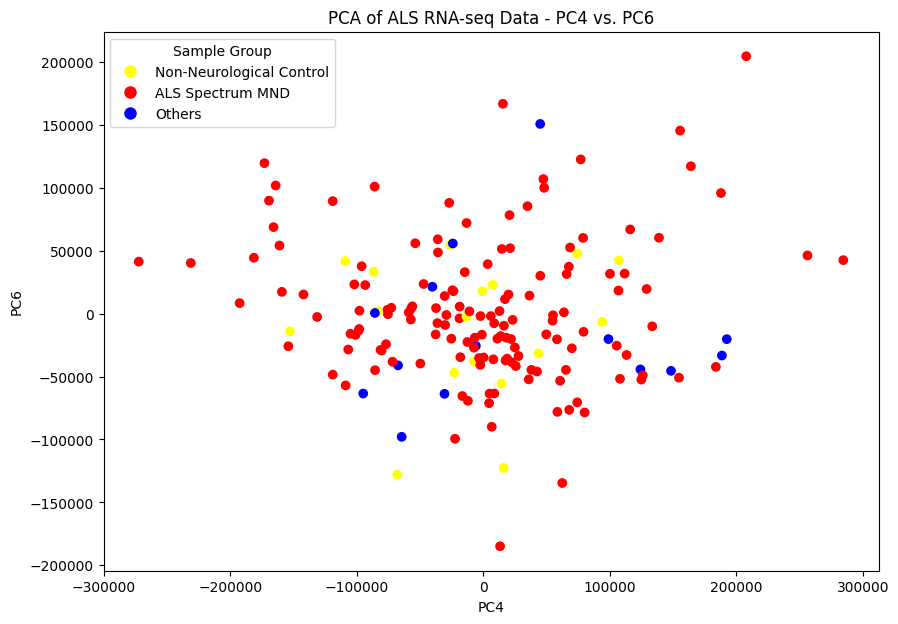

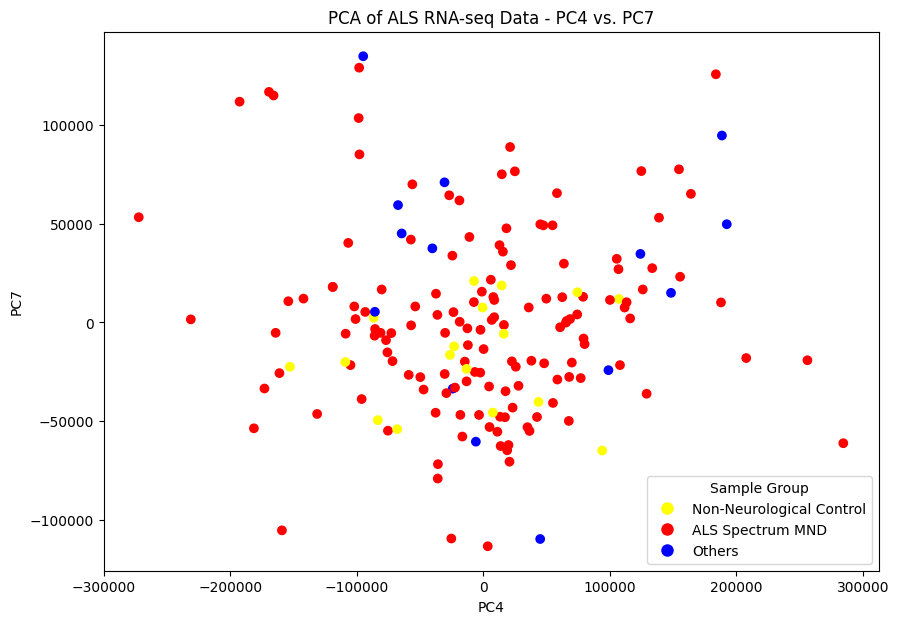

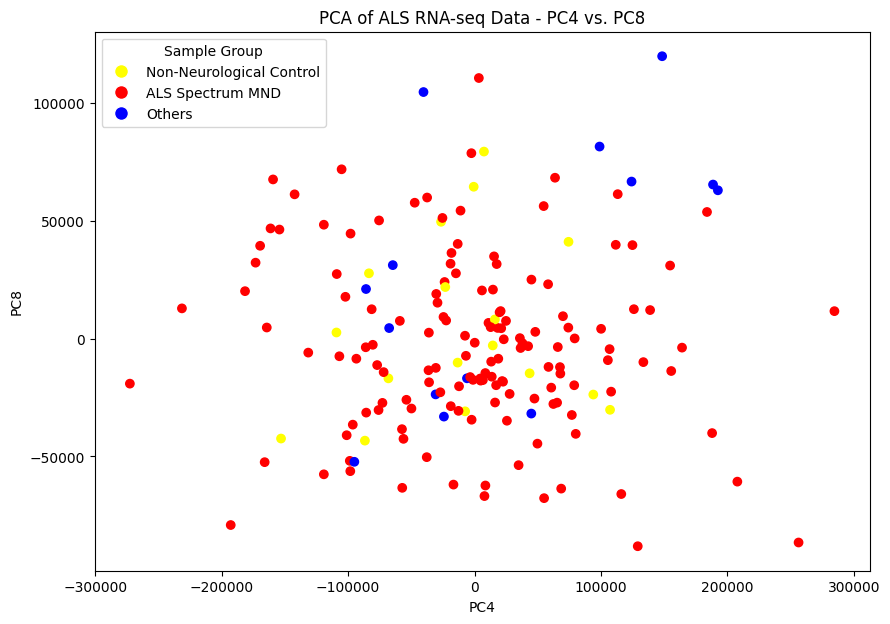

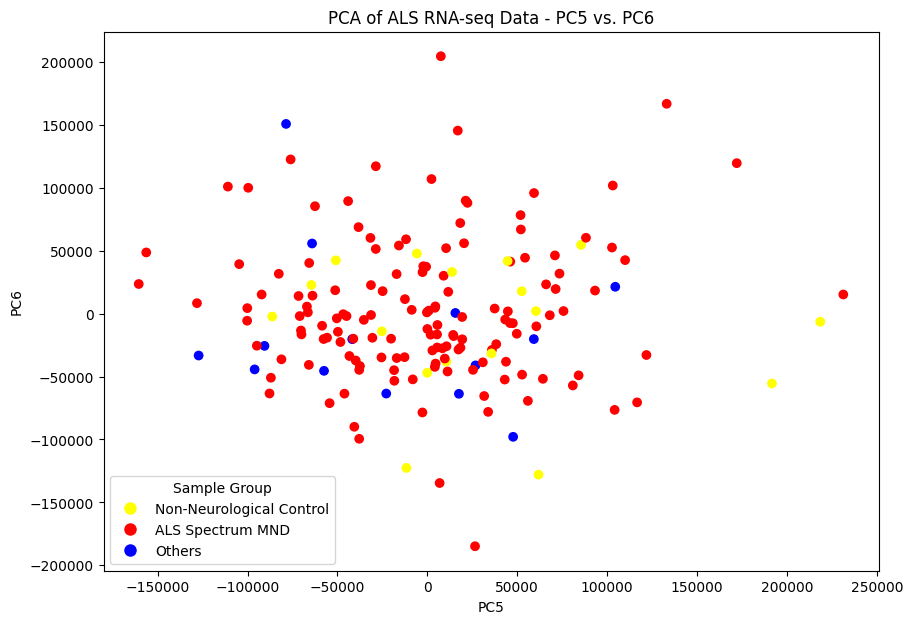

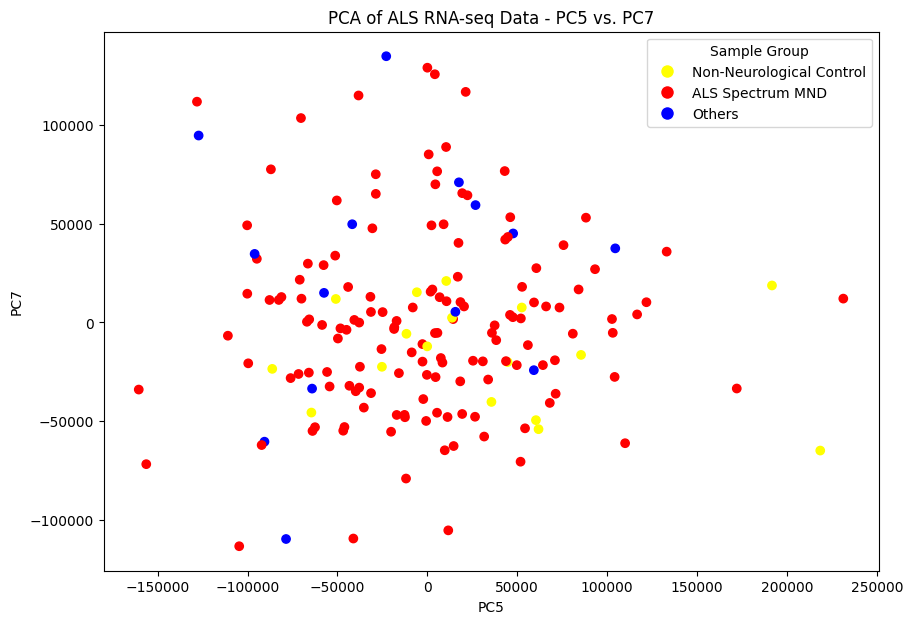

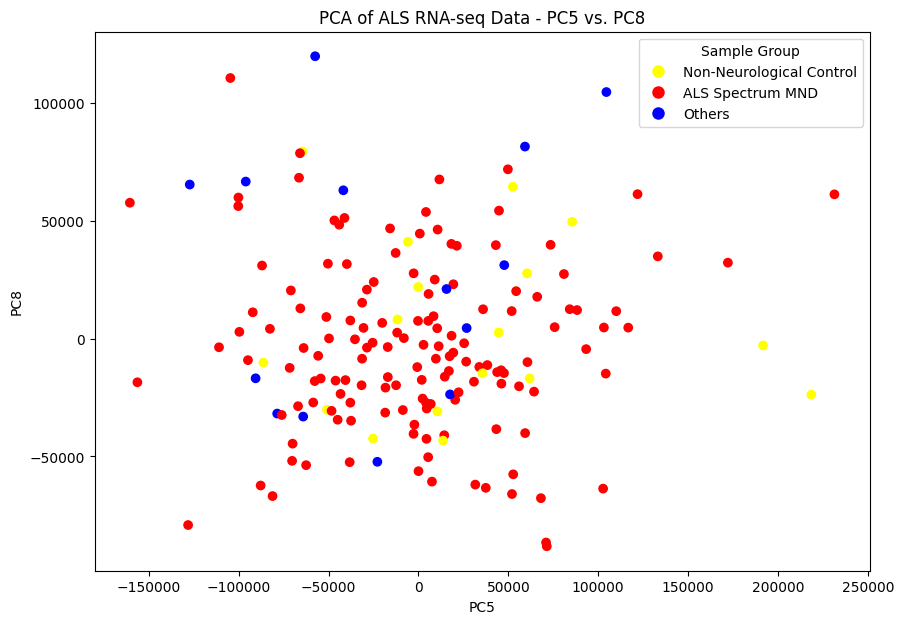

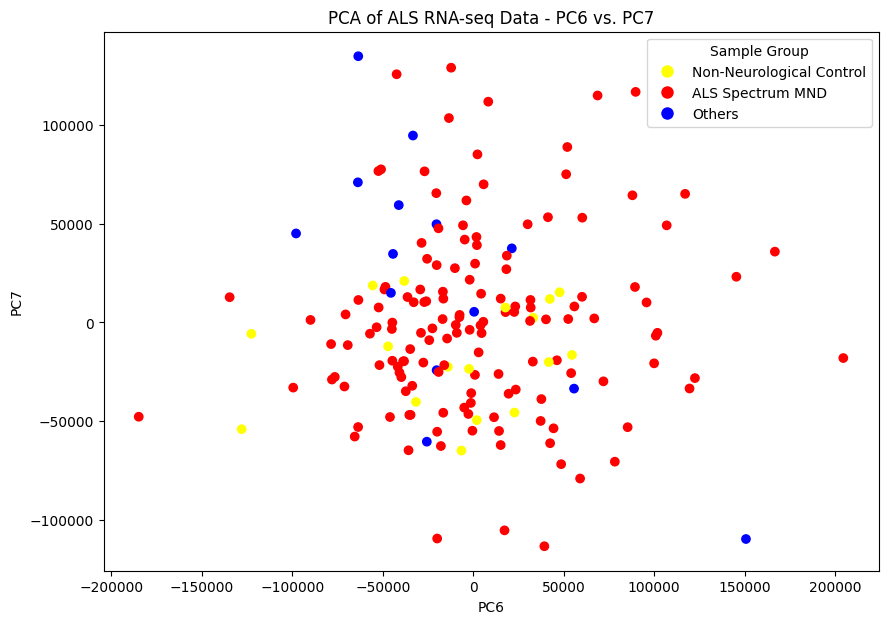

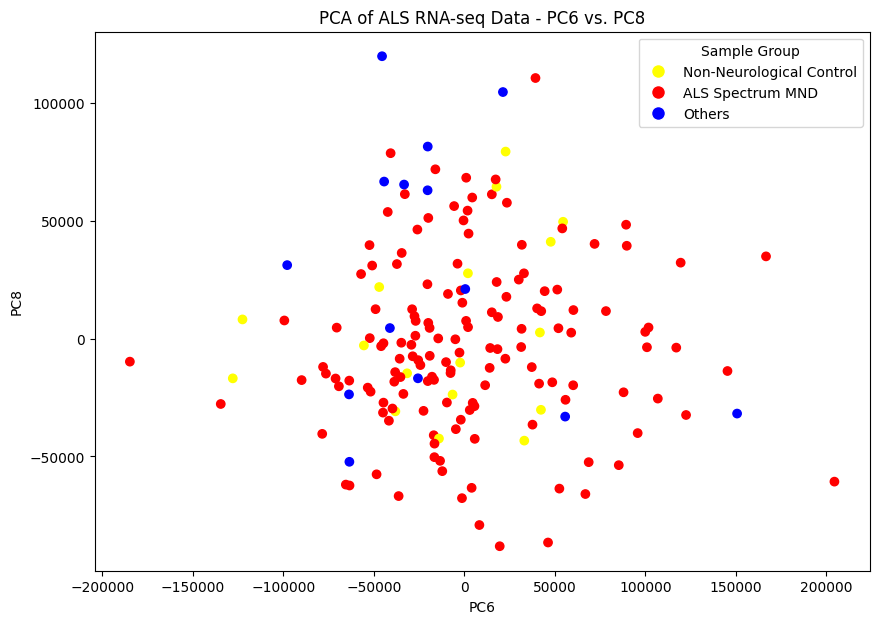

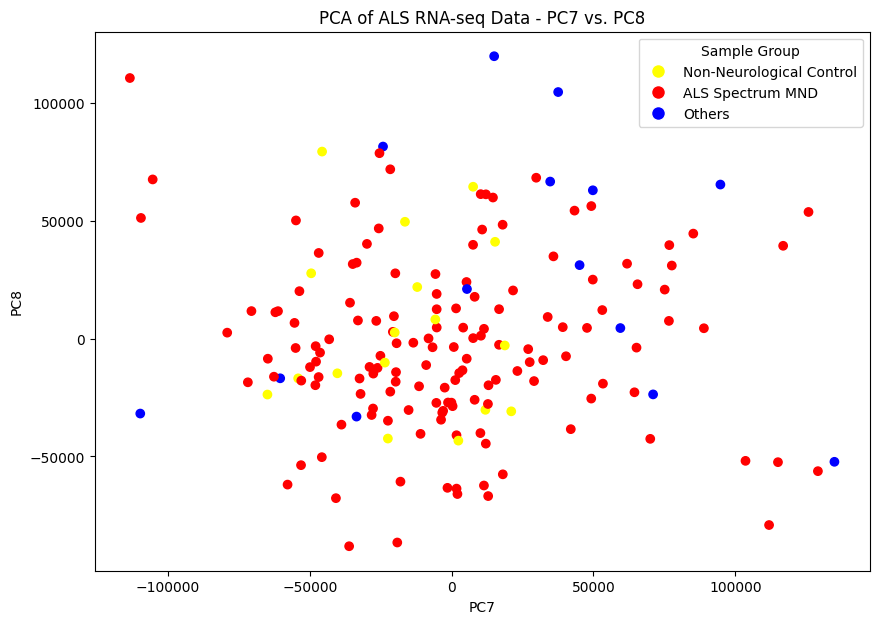

In [7]:
# # Perform PCA analysis
pca_results, variance_ratio, n_components = als_data.perform_pca(variance_threshold = 0.6) # We choose 60% variance threshold to keep the number of components low (fewer figures to plot)
print("PCA analysis completed with " + str(n_components) + "components")

# # Plot PCA results
als_data.plot_pca(pca_results, variance_ratio, n_components)


# Step 4 - tSNE and UMAP

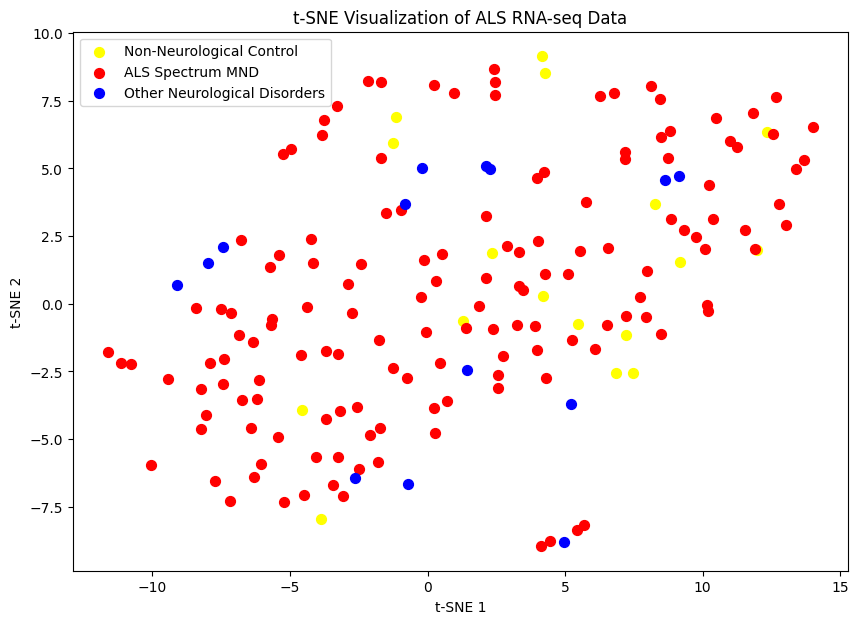

/home/karim/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


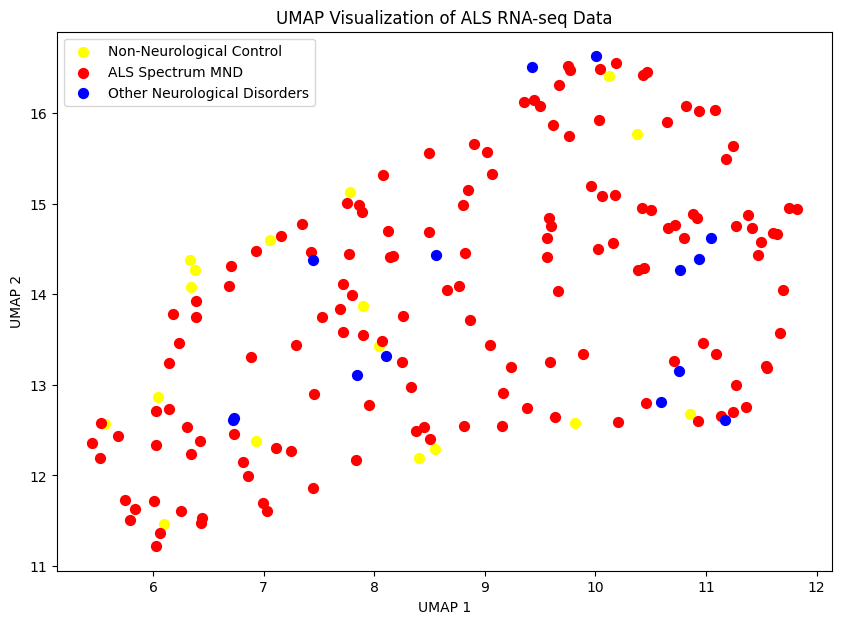

In [8]:

# Perform and plot t-SNE
tsne_results = als_data.perform_tsne()
als_data.plot_dimension_reduction(tsne_results, method_name='t-SNE')

# Perform and plot UMAP
umap_results = als_data.perform_umap()
als_data.plot_dimension_reduction(umap_results, method_name='UMAP')

# Step 5 - Univariate Analysis

/tmp/ipykernel_373812/2664381768.py:383: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.15 seconds.



Fitting dispersions...
... done in 7.21 seconds.

Fitting dispersion trend curve...
... done in 0.50 seconds.

Fitting MAP dispersions...
... done in 11.14 seconds.

Fitting LFCs...
... done in 3.77 seconds.

Replacing 218 outlier genes.

Fitting dispersions...
... done in 0.09 seconds.

Fitting MAP dispersions...
... done in 0.10 seconds.

Fitting LFCs...
... done in 0.08 seconds.

Running Wald tests...
... done in 1.65 seconds.



Log2 fold change & Wald test p-value: sample-group Non-Neurological Control vs ALS Spectrum MND
                           baseMean  log2FoldChange     lfcSE      stat  \
A1BG                      35.993902        0.018089  0.142841  0.126635   
A1BG-AS1                 113.742747        0.052983  0.099893  0.530397   
A1CF                       0.155759       -0.590130  1.710064 -0.345092   
A2M                     2345.384523        0.119104  0.159458  0.746925   
A2M-AS1                   99.268405       -0.186492  0.098238 -1.898364   
...                             ...             ...       ...       ...   
X8_LINE:CR1:LINE         458.855014        0.058600  0.103844  0.564313   
X9_LINE:L1:LINE          109.576015       -0.073882  0.111311 -0.663749   
Zaphod2:hAT-Tip100:DNA   411.010268        0.065308  0.105926  0.616546   
Zaphod3:hAT-Tip100:DNA  1539.491230        0.107348  0.107398  0.999530   
Zaphod:hAT-Tip100:DNA   1710.104347        0.084253  0.097366  0.865318   

   

/tmp/ipykernel_373812/2664381768.py:383: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.15 seconds.

Fitting dispersions...
... done in 6.89 seconds.

Fitting dispersion trend curve...
... done in 0.49 seconds.

Fitting MAP dispersions...
... done in 9.15 seconds.

Fitting LFCs...
... done in 4.07 seconds.

Replacing 218 outlier genes.

Fitting dispersions...
... done in 0.10 seconds.

Fitting MAP dispersions...
... done in 0.11 seconds.

Fitting LFCs...
... done in 0.08 seconds.

Running Wald tests...
... done in 1.76 seconds.



Log2 fold change & Wald test p-value: sample-group Non-Neurological Control vs ALS Spectrum MND
                           baseMean  log2FoldChange     lfcSE      stat  \
A1BG                      35.993902        0.018089  0.142841  0.126635   
A1BG-AS1                 113.742747        0.052983  0.099893  0.530397   
A1CF                       0.155759       -0.590130  1.710064 -0.345092   
A2M                     2345.384523        0.119104  0.159458  0.746925   
A2M-AS1                   99.268405       -0.186492  0.098238 -1.898364   
...                             ...             ...       ...       ...   
X8_LINE:CR1:LINE         458.855014        0.058600  0.103844  0.564313   
X9_LINE:L1:LINE          109.576015       -0.073882  0.111311 -0.663749   
Zaphod2:hAT-Tip100:DNA   411.010268        0.065308  0.105926  0.616546   
Zaphod3:hAT-Tip100:DNA  1539.491230        0.107348  0.107398  0.999530   
Zaphod:hAT-Tip100:DNA   1710.104347        0.084253  0.097366  0.865318   

   

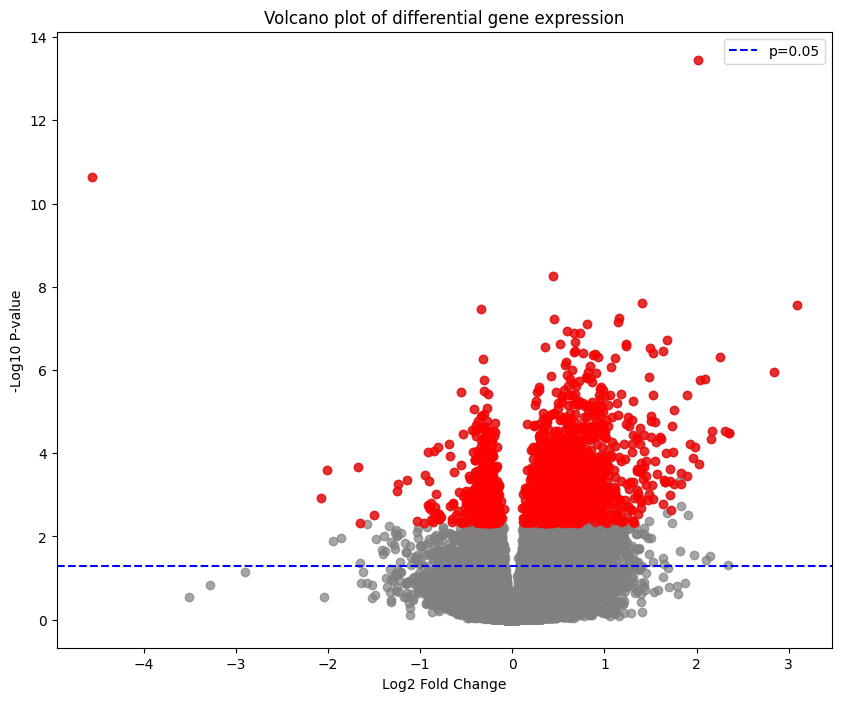

In [9]:
# Perform differential expression analysis
results_df = als_data.perform_differential_expression_analysis()
print("Differential expression analysis completed.")

# Plot volcano plot
als_data.plot_volcano()


# STEP 6 - Multivariate Analysis - Elastic-Net (Option 1)

In [10]:

# Perform Elastic-Net analysis
gene_ranking = als_data.perform_elastic_net()
gene_ranking

ROC AUC on training set: 0.609375
Gene: LOC101927855, Importance: 0.09728356633959769
Gene: ZBTB20-AS4, Importance: 0.07776093642017562
Gene: LOC101927139, Importance: 0.0759382960554226
Gene: MIR3621, Importance: 0.0754253905146652
Gene: LOC105379807, Importance: 0.07064292726889246
Gene: LOC283435, Importance: 0.06891841394112877
Gene: MIR4676, Importance: 0.06697785381540494
Gene: CES1P2, Importance: 0.06615294328447731
Gene: GSTTP2, Importance: 0.06201655695701363
Gene: LINC01558, Importance: 0.06002544893624503


[('LOC101927855', 0.09728356633959769),
 ('ZBTB20-AS4', 0.07776093642017562),
 ('LOC101927139', 0.0759382960554226),
 ('MIR3621', 0.0754253905146652),
 ('LOC105379807', 0.07064292726889246),
 ('LOC283435', 0.06891841394112877),
 ('MIR4676', 0.06697785381540494),
 ('CES1P2', 0.06615294328447731),
 ('GSTTP2', 0.06201655695701363),
 ('LINC01558', 0.06002544893624503),
 ('LOC100506403', 0.05922415126511494),
 ('LOC100499194', 0.05771688611525588),
 ('LINC01972', 0.05735723050150733),
 ('KRT7', 0.055231154067935606),
 ('MIR3650', 0.05475660862984462),
 ('HSPC324', 0.05386171683300182),
 ('CAPN11', 0.05258277265941557),
 ('FAM83C', 0.05216751973873337),
 ('MIR8077', 0.05131813039847797),
 ('PSD2-AS1', 0.05120969584615634),
 ('LINC01072', 0.050618061422506924),
 ('LOC101928523', 0.04980443441392258),
 ('GK3P', 0.04902036223914331),
 ('MYL1', 0.0483135724590067),
 ('CRYBA1', 0.048133638158062604),
 ('MBD3L3', 0.047717876451676466),
 ('MIRLET7F2', 0.04685098878471449),
 ('GJB3', 0.0449775222212

# STEP 7 - XGBOOST (Option 2)

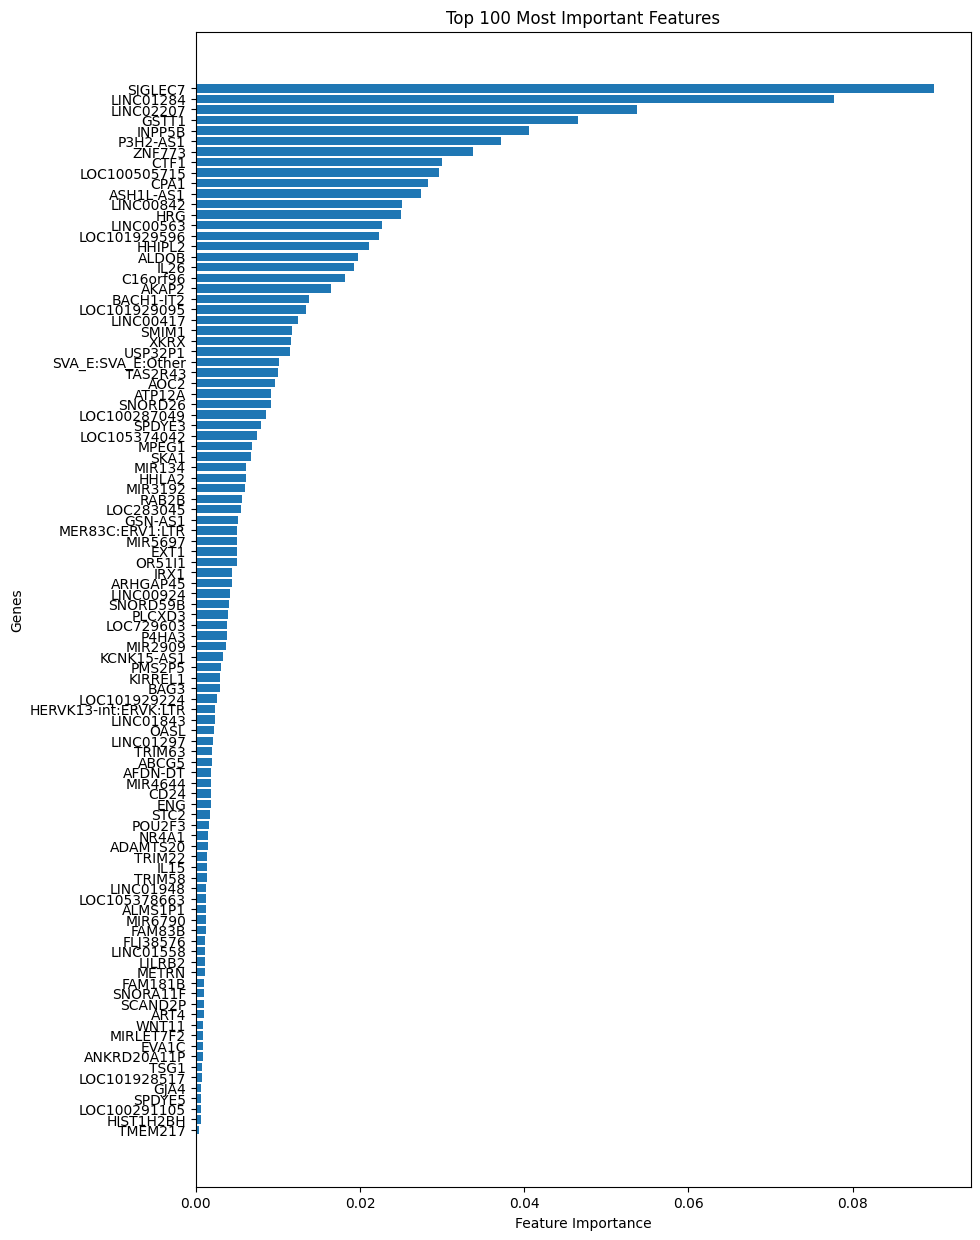

Accuracy on validation set: 0.8611111111111112
Balanced Accuracy on validation set: 0.484375


,Gene,Importance
20976,SIGLEC7,0.089899
10445,LINC01284,0.077689
11083,LINC02207,0.053757
7615,GSTT1,0.046585
8737,INPP5B,0.040641
...,...,...
7112,GJA4,0.000648
22418,SPDYE5,0.000619
11600,LOC100291105,0.000601
8016,HIST1H2BH,0.000594


In [11]:

# Perform XGBoost analysis
top_features_xgboost = als_data.perform_xgboost_analysis()
top_features_xgboost

# STEP 8 - Results report

/tmp/ipykernel_373812/2664381768.py:383: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.15 seconds.

Fitting dispersions...
... done in 7.07 seconds.

Fitting dispersion trend curve...
... done in 0.53 seconds.

Fitting MAP dispersions...
... done in 21.94 seconds.

Fitting LFCs...
... done in 4.85 seconds.

Replacing 218 outlier genes.

Fitting dispersions...
... done in 0.11 seconds.

Fitting MAP dispersions...
... done in 0.12 seconds.

Fitting LFCs...
... done in 0.09 seconds.

Running Wald tests...
... done in 1.76 seconds.



Log2 fold change & Wald test p-value: sample-group Non-Neurological Control vs ALS Spectrum MND
                           baseMean  log2FoldChange     lfcSE      stat  \
A1BG                      35.993902        0.018089  0.142841  0.126635   
A1BG-AS1                 113.742747        0.052983  0.099893  0.530397   
A1CF                       0.155759       -0.590130  1.710064 -0.345092   
A2M                     2345.384523        0.119104  0.159458  0.746925   
A2M-AS1                   99.268405       -0.186492  0.098238 -1.898364   
...                             ...             ...       ...       ...   
X8_LINE:CR1:LINE         458.855014        0.058600  0.103844  0.564313   
X9_LINE:L1:LINE          109.576015       -0.073882  0.111311 -0.663749   
Zaphod2:hAT-Tip100:DNA   411.010268        0.065308  0.105926  0.616546   
Zaphod3:hAT-Tip100:DNA  1539.491230        0.107348  0.107398  0.999530   
Zaphod:hAT-Tip100:DNA   1710.104347        0.084253  0.097366  0.865318   

   

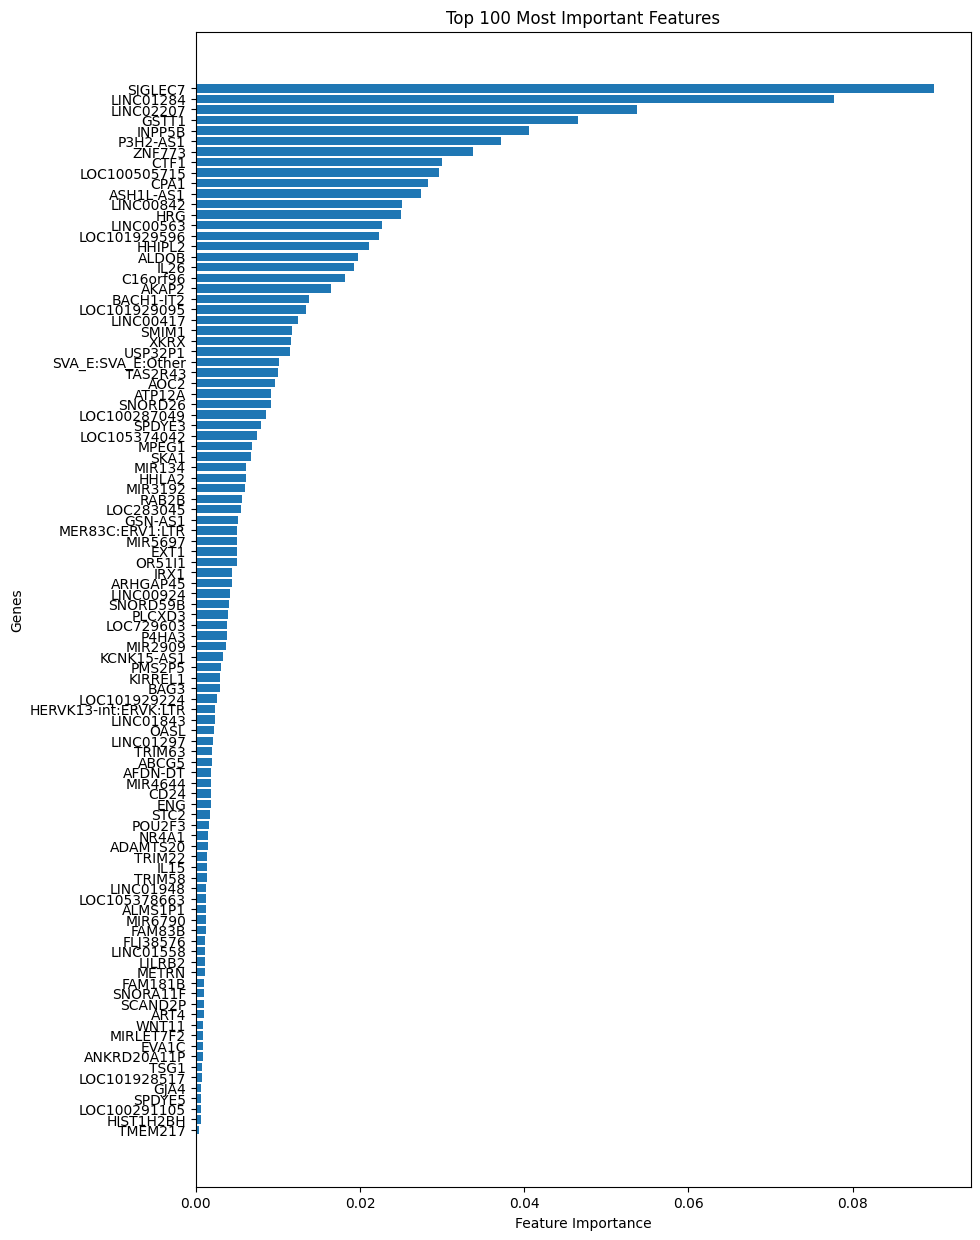

Accuracy on validation set: 0.8611111111111112
Balanced Accuracy on validation set: 0.484375
               Gene  EN_Importance  EN_Rank  Importance  XGB_Rank  DEA_Score  \
21866       SIGLEC7       0.000000    566.0    1.000000       1.0   0.053838   
12273  LOC101927855       1.000000      1.0    0.000000       NaN   0.005429   
10772     LINC01284       0.000000    566.0    0.864181       2.0   0.140978   
790      ANKRD20A9P       0.000000    566.0    0.000000       NaN   1.000000   
14020    MAPK8IP1P2       0.000000    566.0    0.000000       NaN   0.982265   
...             ...            ...      ...         ...       ...        ...   
10099          LGR6       0.000000    566.0    0.000000       NaN   0.447805   
18450          PATJ       0.000000    566.0    0.000000       NaN   0.445720   
12701  LOC102724601       0.414242     43.0    0.000000       NaN   0.031028   
23260     SPATA31A7       0.000000    566.0    0.000000       NaN   0.442504   
23258     SPATA31A5       0

,Gene,EN_Importance,EN_Rank,Importance,XGB_Rank,DEA_Score,Combined_Importance,Final_Rank
21866,SIGLEC7,0.000000,566.0,1.000000,1.0,0.053838,1.053838,1.0
12273,LOC101927855,1.000000,1.0,0.000000,NaN,0.005429,1.005429,2.0
10772,LINC01284,0.000000,566.0,0.864181,2.0,0.140978,1.005159,3.0
790,ANKRD20A9P,0.000000,566.0,0.000000,NaN,1.000000,1.000000,4.0
14020,MAPK8IP1P2,0.000000,566.0,0.000000,NaN,0.982265,0.982265,5.0
...,...,...,...,...,...,...,...,...
10099,LGR6,0.000000,566.0,0.000000,NaN,0.447805,0.447805,96.0
18450,PATJ,0.000000,566.0,0.000000,NaN,0.445720,0.445720,97.0
12701,LOC102724601,0.414242,43.0,0.000000,NaN,0.031028,0.445270,98.0
23260,SPATA31A7,0.000000,566.0,0.000000,NaN,0.442504,0.442504,99.0


In [12]:

# Aggregate rankings
top_100_genes = als_data.aggregate_rankings()
top_100_genes.to_csv('top_100_genes.csv', index=False)
top_100_genes